In [1]:

import os
import math

import mne
import numpy as np
import scipy
from einops import rearrange, repeat
from einops.layers.torch import Rearrange, Reduce
import torch
from torch import nn, LongTensor
from torch.utils.data import TensorDataset

from renaanalysis.utils.utils import visualize_eeg_epochs
from torch import optim, nn
from torch.optim import lr_scheduler
from sklearn import preprocessing
from renaanalysis.utils.data_utils import z_norm_by_trial
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import Tensor

User parameters

In [2]:
# data_root = r'C:\Users\apoca\Downloads'
data_root = r'D:\Dropbox\Dropbox\EEGDatasets\BCICompetitionIV2a'

subject = 'A03'
eeg_channels = {'Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6',  'CP3', 'CP1', 'CPz',  'CP2', 'CP4', 'P1', 'Pz', 'P2', 'POz'}
srate = 250
montage = mne.channels.make_standard_montage('standard_1020')
lowcut_eeg = 4
highcut_eeg = 40
n_jobs = 1
epoch_tmin = 0.
epoch_tmax = 4.
event_id = {'left': 1, 'right': 2, 'foot': 3, 'tongue': 4}



Load the data

In [3]:

def load_mat_sessions(file_path, figure_title):
    event_viz_colors = {'left': 'red', 'right': 'blue', 'foot': 'green', 'tongue': 'yellow'}
    this_epoch_tmax = epoch_tmax - 1 / srate
    data = scipy.io.loadmat(file_path)['data']
    all_epochs = []
    for session_i in range(data.shape[1]):
        ys = data[0, session_i]['y'][0, 0]
        if len(ys) == 0:
            print(f"session {session_i} of {data.shape[1]} does not have labels, skipping")
            continue
        # the last three channels are eog, so we skip them
        eeg = data[0, session_i]['X'][0, 0][:, :-3]
        trial_start_indices = data[0, session_i]['trial'][0, 0]
        # create mne data structure
        info = mne.create_info(ch_names=list(eeg_channels), sfreq=srate, ch_types='eeg')
        raw = mne.io.RawArray(eeg.T, info)
        raw.set_montage(montage)
        # raw, _ = mne.set_eeg_reference(raw, 'average', projection=False)
        # raw = raw.filter(l_freq=lowcut_eeg, h_freq=highcut_eeg, n_jobs=n_jobs, picks='eeg')
        
        # create events array from trial start indices
        events = np.array(np.concatenate([trial_start_indices, np.zeros((len(trial_start_indices), 1)), ys], axis=1), dtype=int)
        epoch = mne.Epochs(raw, events, event_id=event_id, tmin=epoch_tmin, tmax=this_epoch_tmax,
                      baseline=(epoch_tmin, epoch_tmin + (epoch_tmax - epoch_tmin) * 0.1), preload=True,
                      event_repeated='drop')
        all_epochs.append(epoch)
    epochs = mne.concatenate_epochs(all_epochs)
    visualize_eeg_epochs(epochs, event_id, event_viz_colors, tmin_eeg_viz=epoch_tmin, tmax_eeg_viz=epoch_tmax, eeg_picks=eeg_channels, title=figure_title)
    return epochs




In [4]:
from renaanalysis.utils.dataset_utils import get_BCI_montage


def load_gdf_sessions(train_file_path, val_file_path, figure_title):
    event_viz_colors = {'769': 'red', '770': 'blue', '771': 'green', '772': 'yellow'}
    channel_mapping = {'EEG-Fz': 'Fz', 'EEG-0': 'FC3', 'EEG-1': 'FC1', 'EEG-2': 'FCz', 'EEG-3': 'FC2', 'EEG-4': 'FC4', 'EEG-5': 'C5', 'EEG-C3': 'C3', 'EEG-6': 'C1', 'EEG-Cz': 'Cz', 'EEG-7': 'C2', 'EEG-C4': 'C4', 'EEG-8': 'C6', 'EEG-9': 'CP3', 'EEG-10': 'CP1', 'EEG-11': 'CPz', 'EEG-12': 'CP2', 'EEG-13': 'CP4', 'EEG-14': 'P1', 'EEG-Pz': 'Pz', 'EEG-15': 'P2', 'EEG-16': 'POz'}
    kept_channels = ['Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP3', 'CP1',
                 'CPz', 'CP2', 'CP4', 'P1', 'Pz', 'P2', 'POz']
    event_id_mapping = {'769': 0, '770': 1, '771': 2, '772': 3, '783': 7}
    
    this_epoch_tmax = epoch_tmax - 1 / srate
    raw_train = mne.io.read_raw_gdf(train_file_path, preload=True)
    # raw_train, _ = mne.set_eeg_reference(raw_train, 'average', projection=False)
    mont1020 = get_BCI_montage('standard_1020', picks=kept_channels)

    raw_val = mne.io.read_raw_gdf(val_file_path, preload=True)
    # raw_val, _ = mne.set_eeg_reference(raw_val, 'average', projection=False)

    raw = mne.concatenate_raws([raw_train, raw_val])
    mne.rename_channels(raw.info, channel_mapping)
    
    raw.drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])  # otherwise the channel names are not consistent with montage
    raw.set_montage(mont1020)
    events, event_id = mne.events_from_annotations(raw, event_id=event_id_mapping)
    
    data = mne.Epochs(raw, events, event_id=event_id, tmin=epoch_tmin, tmax=this_epoch_tmax,
                  baseline=(epoch_tmin, epoch_tmin + (epoch_tmax - epoch_tmin) * 0.1), preload=True,
                  event_repeated='drop')
                # add the labels to the val epochs
    val_len = np.sum(events[:, -1] == event_id_mapping['783'])
    true_label_path_eval = os.path.join(data_root, 'true_labels', f'A03E.mat')
    true_label_eval = scipy.io.loadmat(true_label_path_eval)

    true_label_path_train = os.path.join(data_root, 'true_labels', f'A03T.mat')
    true_label_train = scipy.io.loadmat(true_label_path_train)
    assert np.all(data.events[:, -1][events[:, -1] != event_id_mapping['783']] == (true_label_train['classlabel'] - 1).squeeze(axis=-1)), f"Labels don't match for subject train"

    # data.events[:, -1] = (true_label['classlabel'] - 1).squeeze(axis=-1)
    # data.event_id = {'769': 0, '770': 1, '771': 2, '772': 3}
    assert np.all(np.argwhere(events[:, -1] == event_id_mapping['783'])[:, 0] == np.arange(288, len(data))), f"Labels don't match for eval"
    data.events[:, -1][events[:, -1] == event_id_mapping['783']] = (true_label_eval['classlabel'] - 1).squeeze(axis=-1)
    data.event_id.pop('783')
    visualize_eeg_epochs(data, event_id, event_viz_colors, tmin_eeg_viz=epoch_tmin, tmax_eeg_viz=epoch_tmax, eeg_picks=eeg_channels, title=figure_title)
    return data[:val_len], data[val_len:]

Extracting EDF parameters from D:\Dropbox\Dropbox\EEGDatasets\BCICompetitionIV2a\A03T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 660529  =      0.000 ...  2642.116 secs...


C:\Users\apoca\AppData\Local\Programs\Python\Python39\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Extracting EDF parameters from D:\Dropbox\Dropbox\EEGDatasets\BCICompetitionIV2a\A03E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 648774  =      0.000 ...  2595.096 secs...


C:\Users\apoca\AppData\Local\Programs\Python\Python39\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['769', '770', '771', '772', '783']
Not setting metadata
576 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 576 events and 1000 original time points ...
0 bad epochs dropped


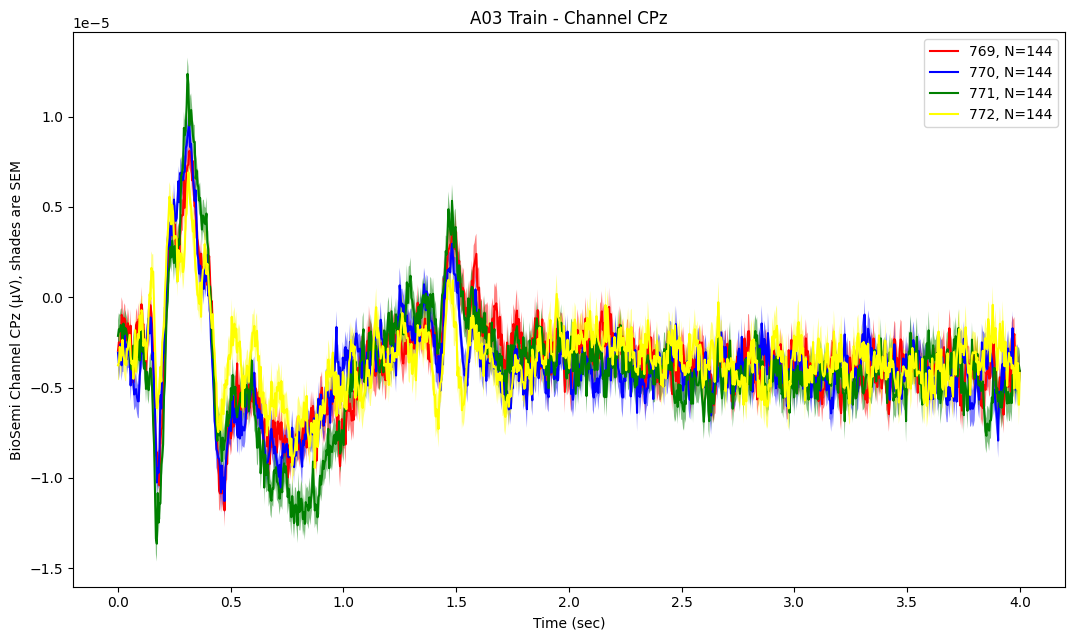

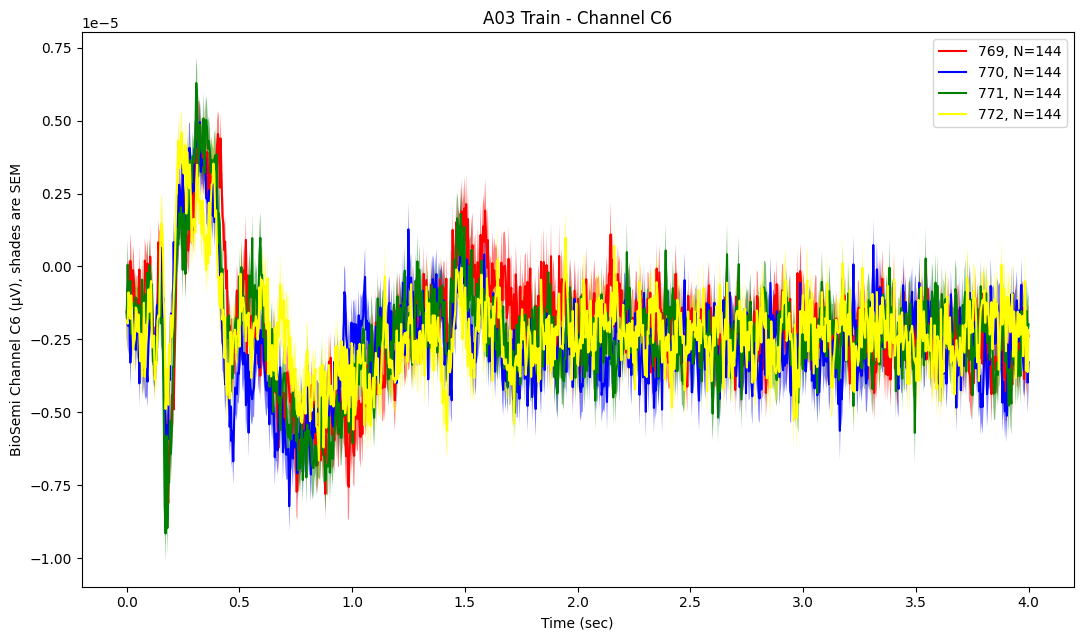

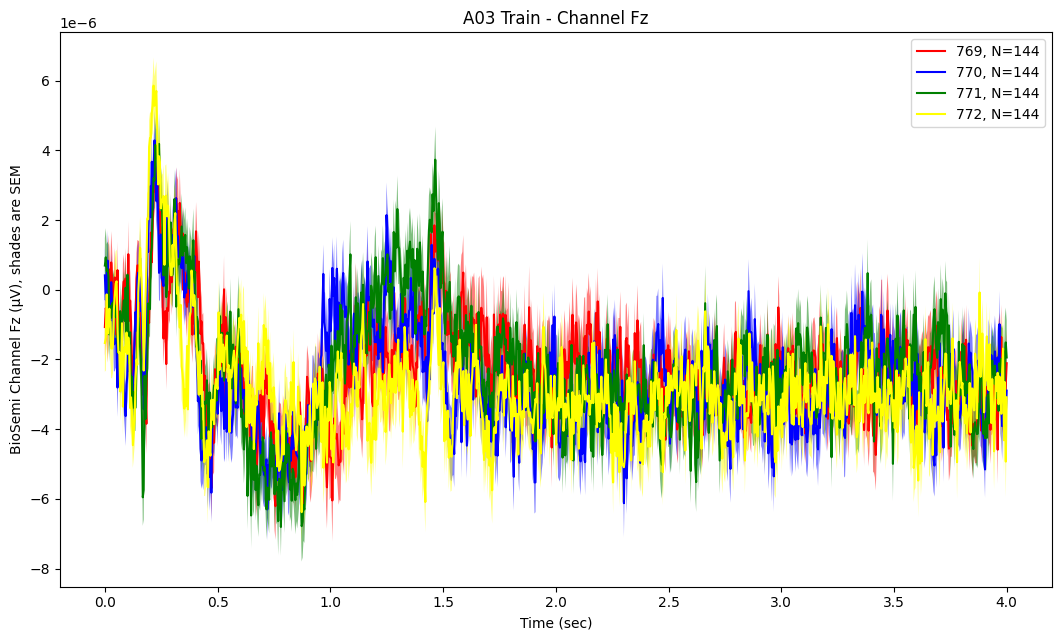

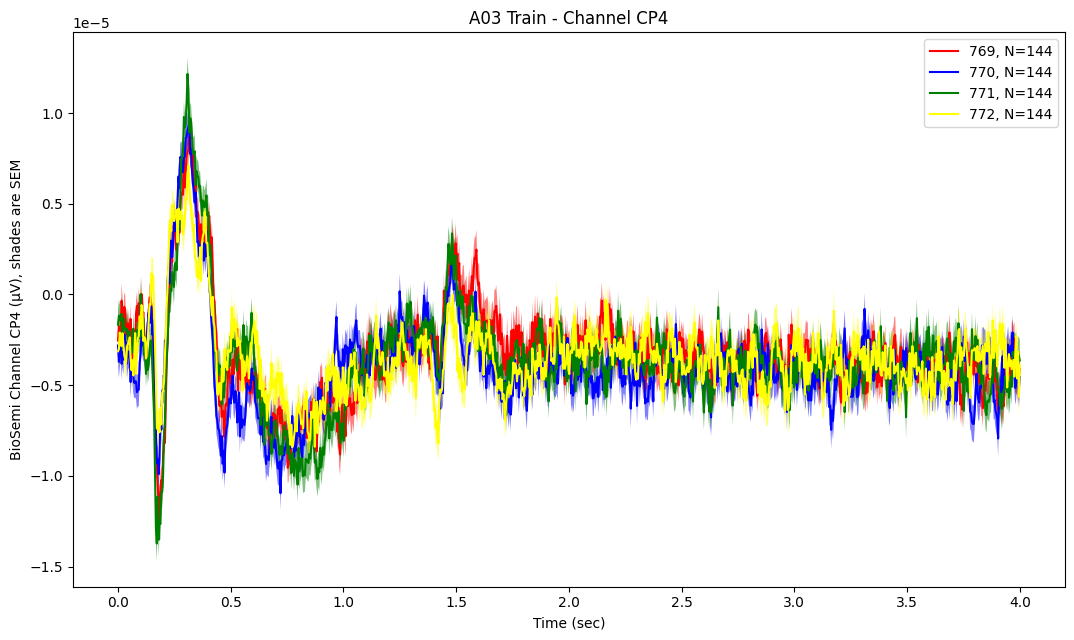

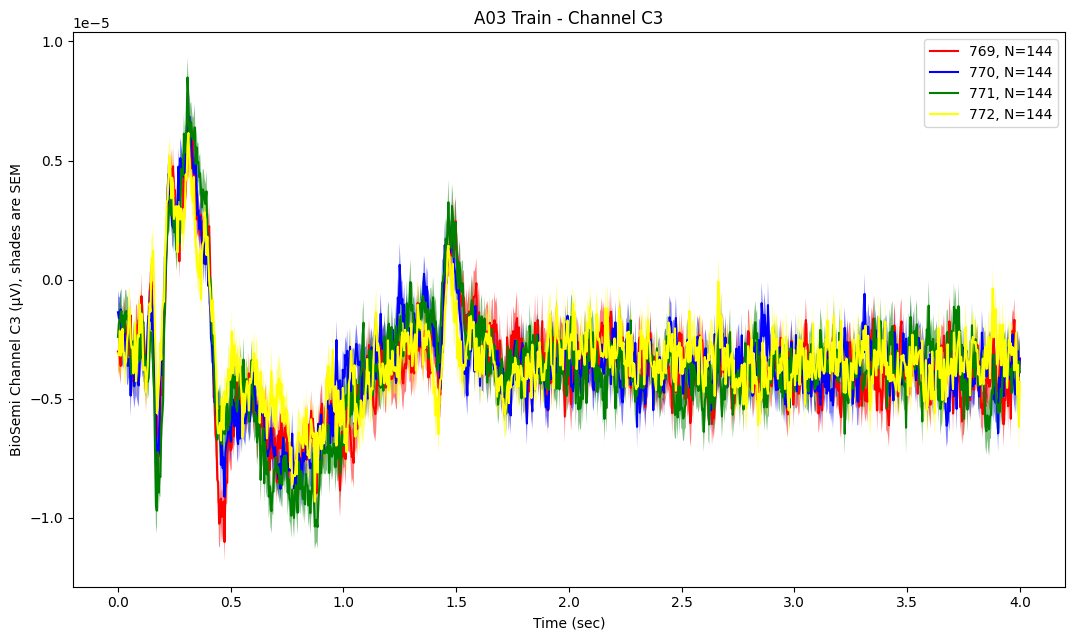

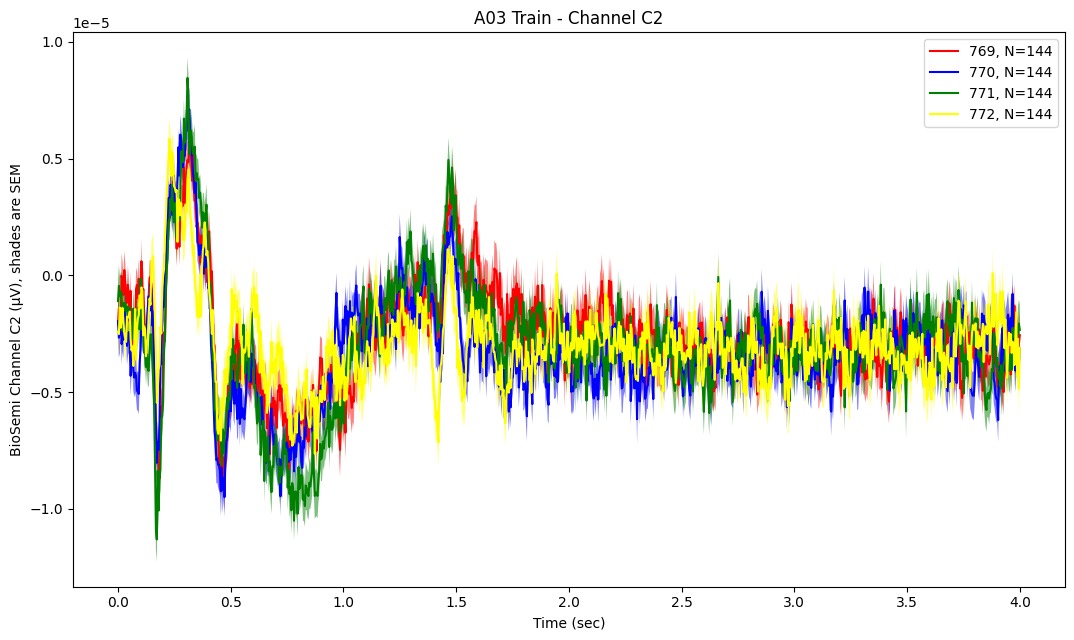

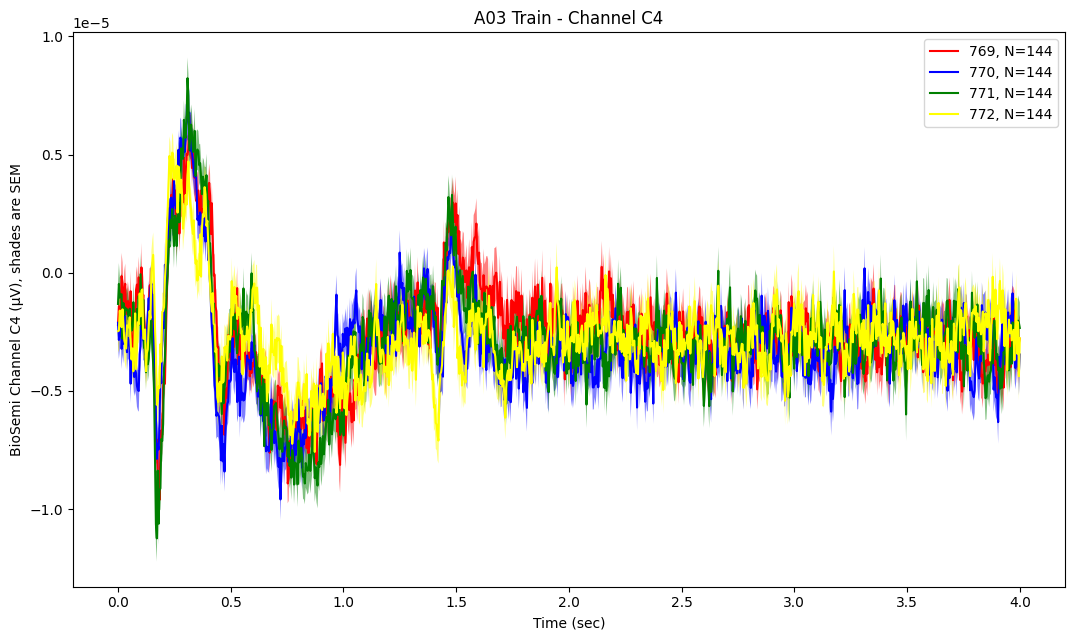

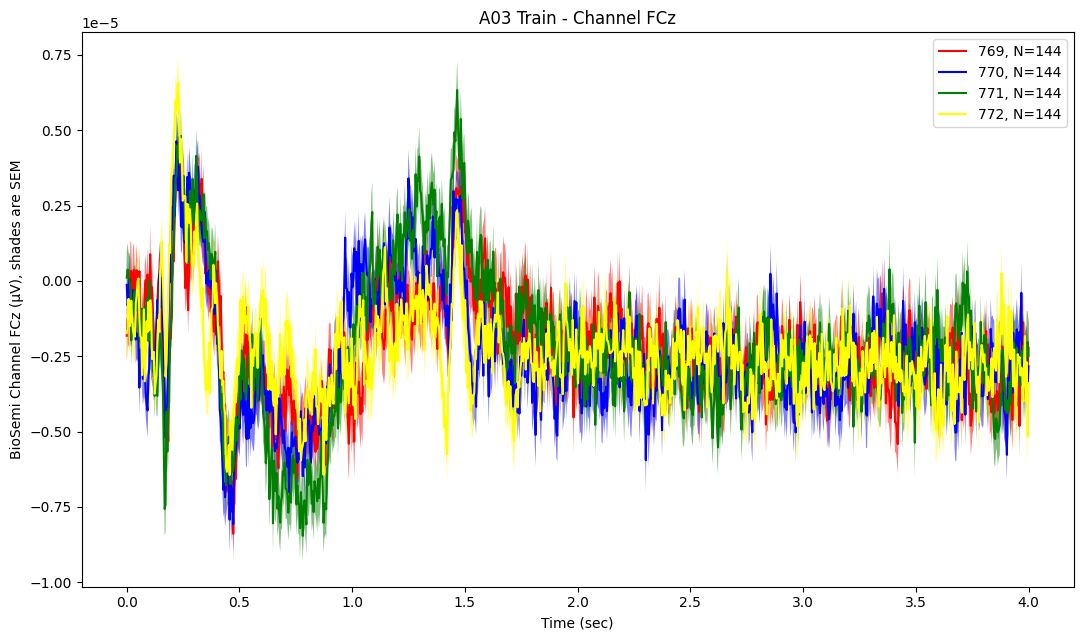

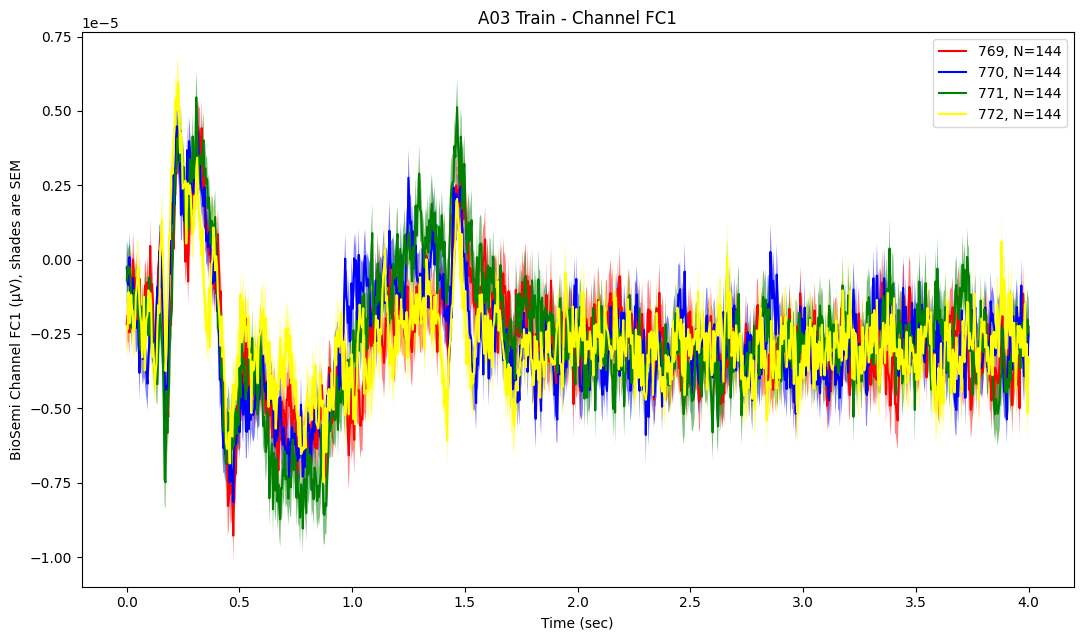

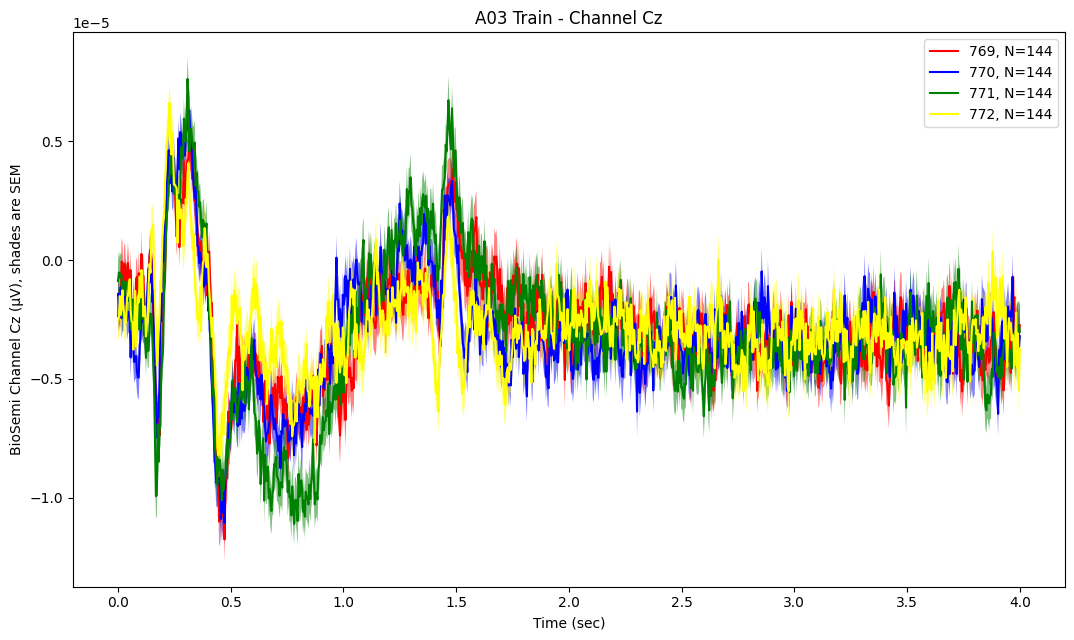

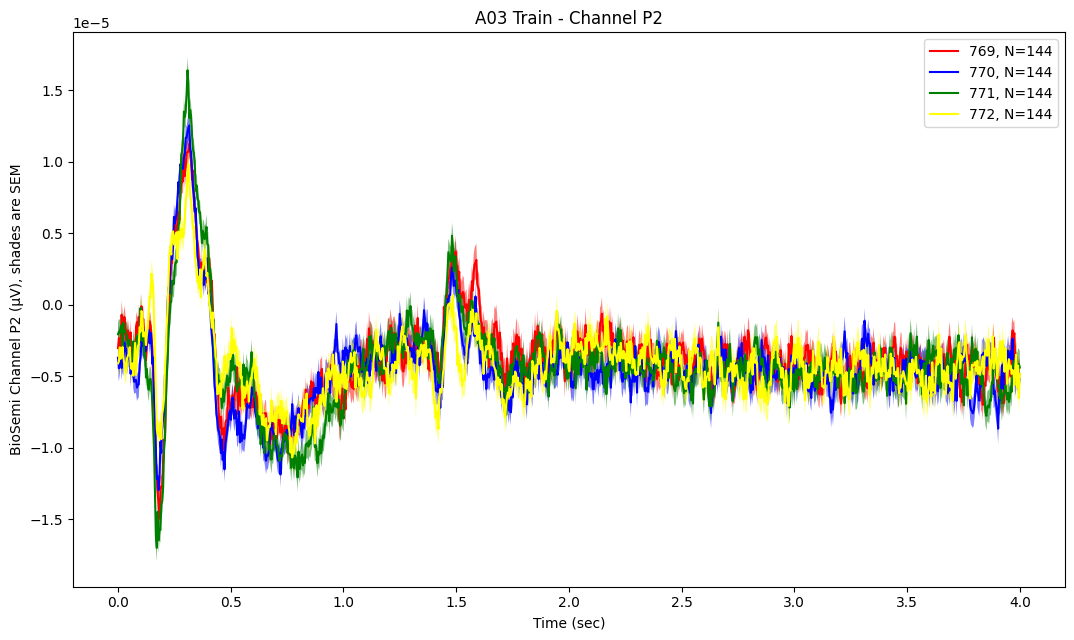

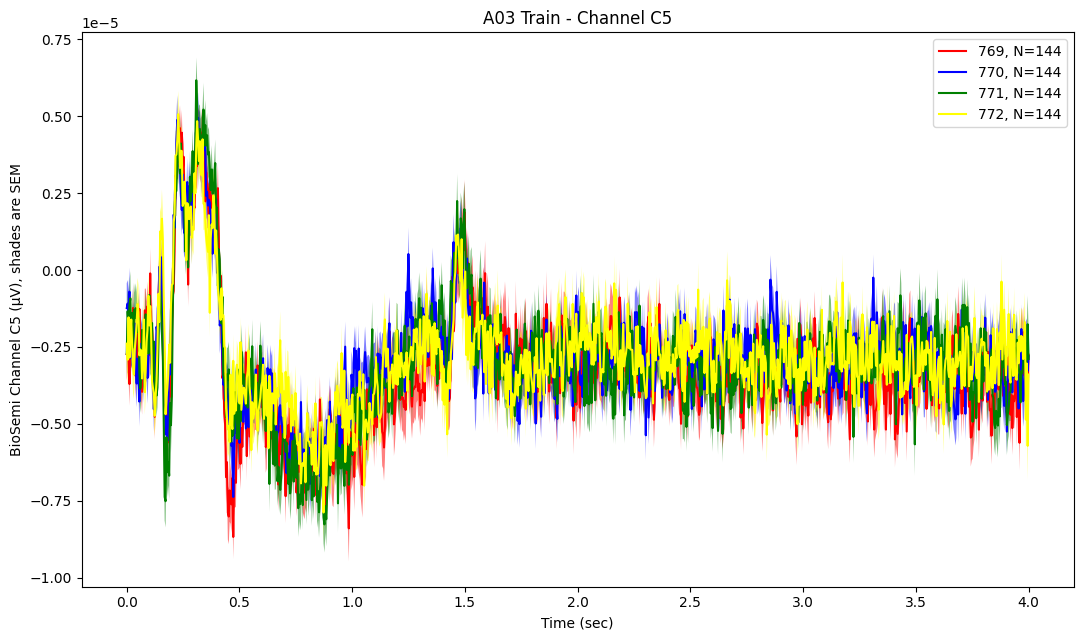

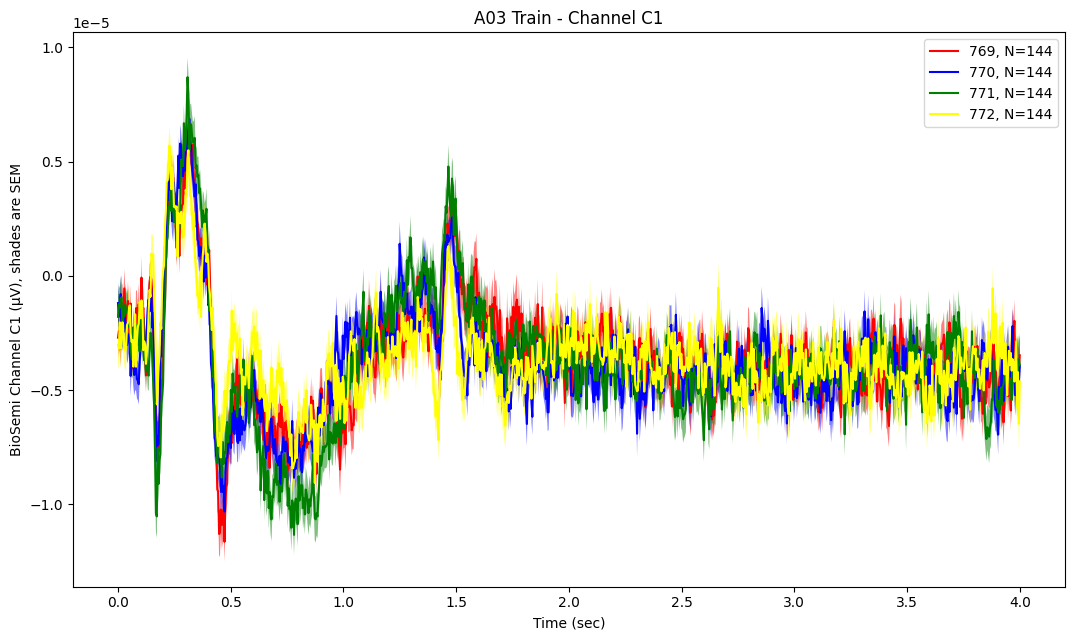

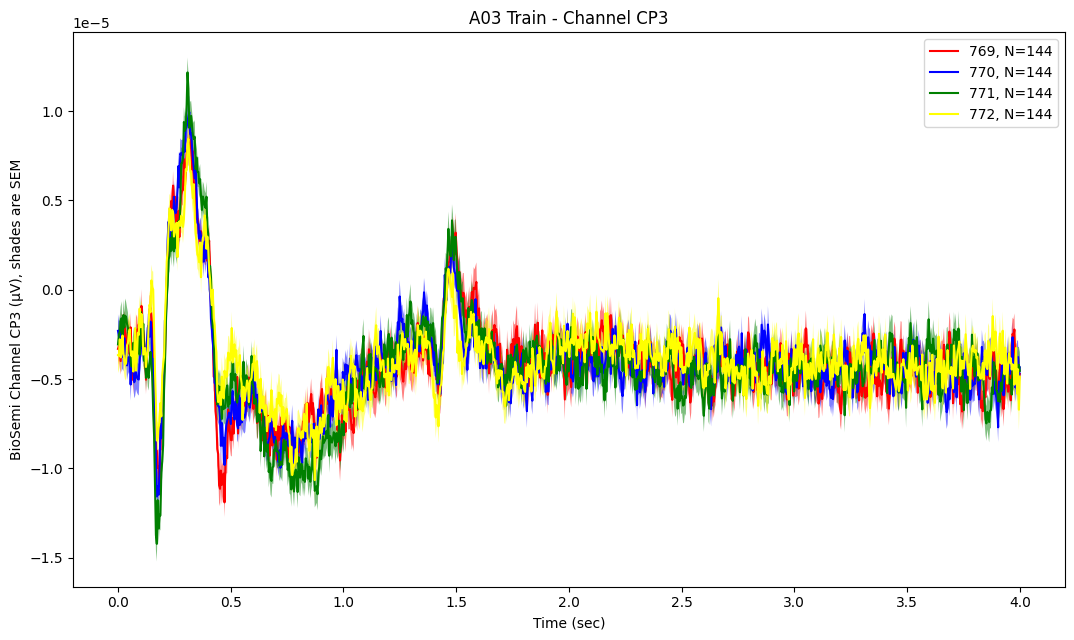

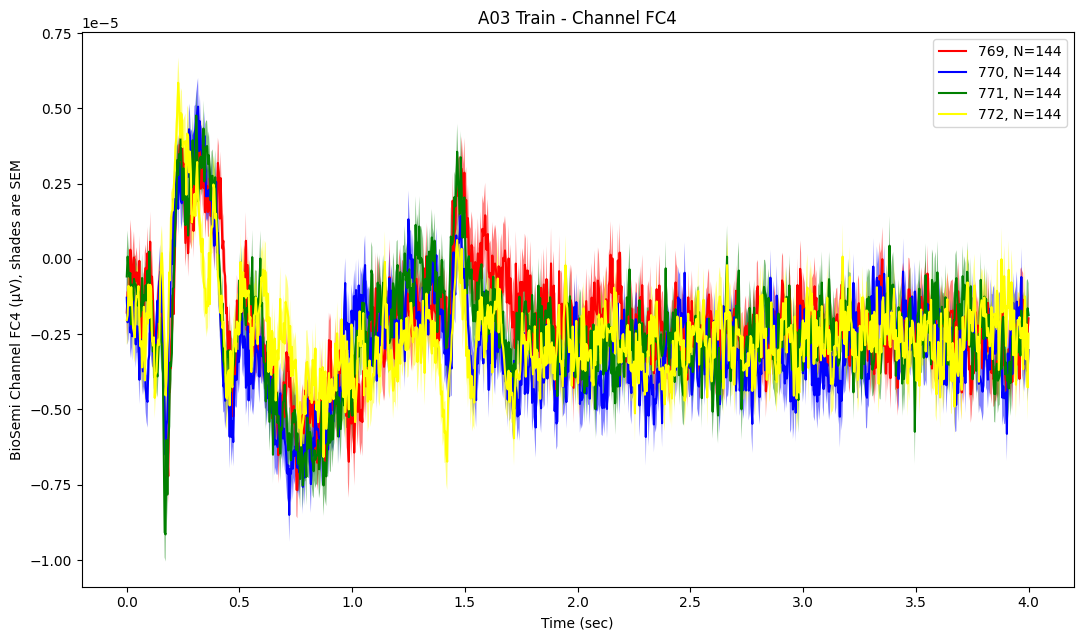

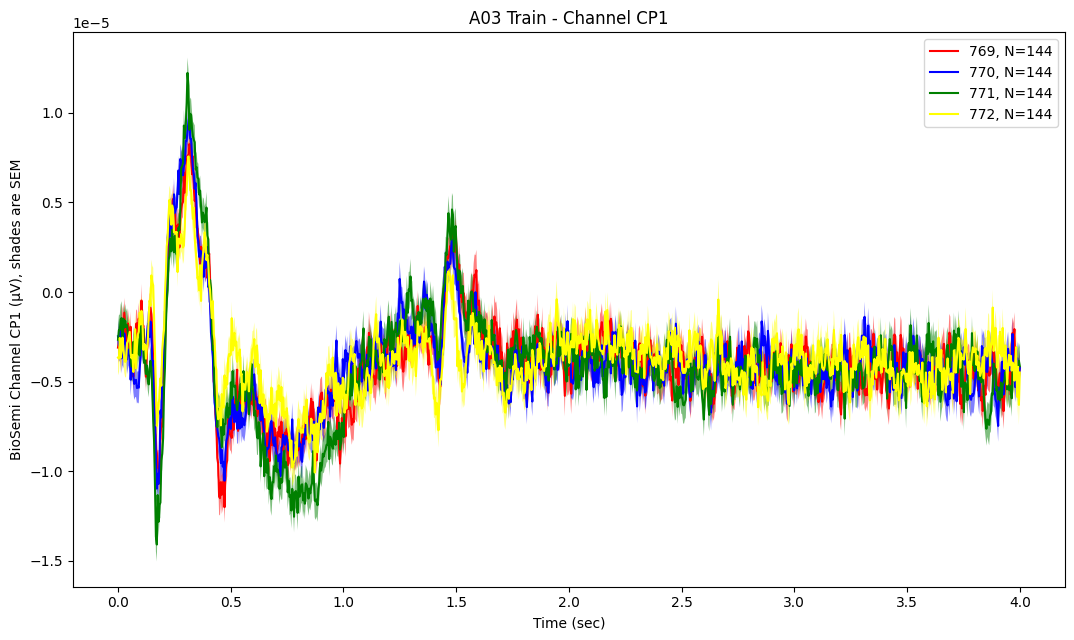

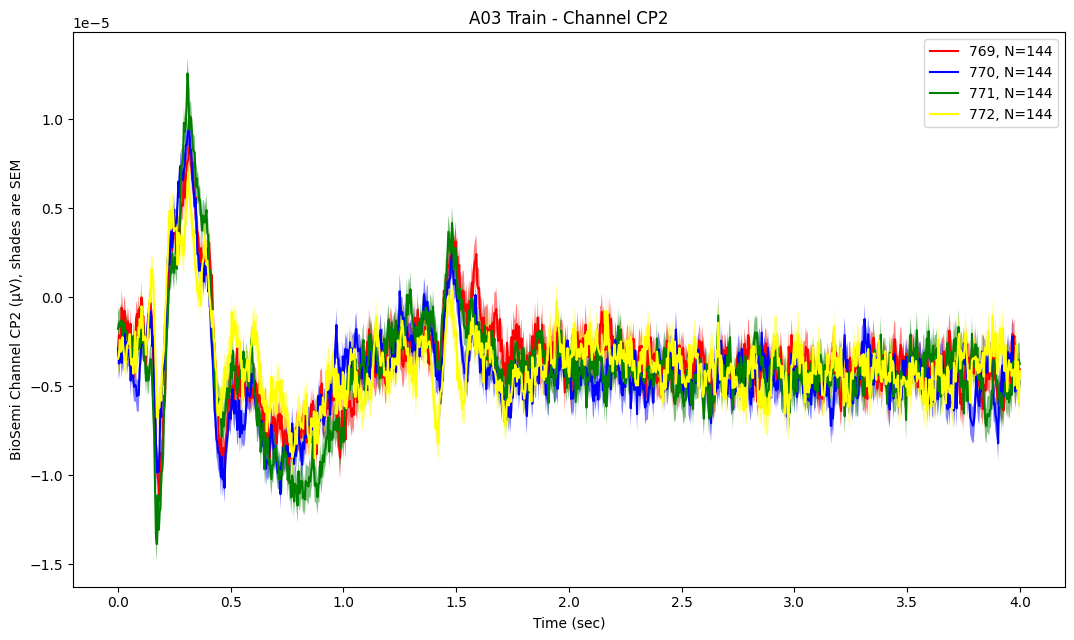

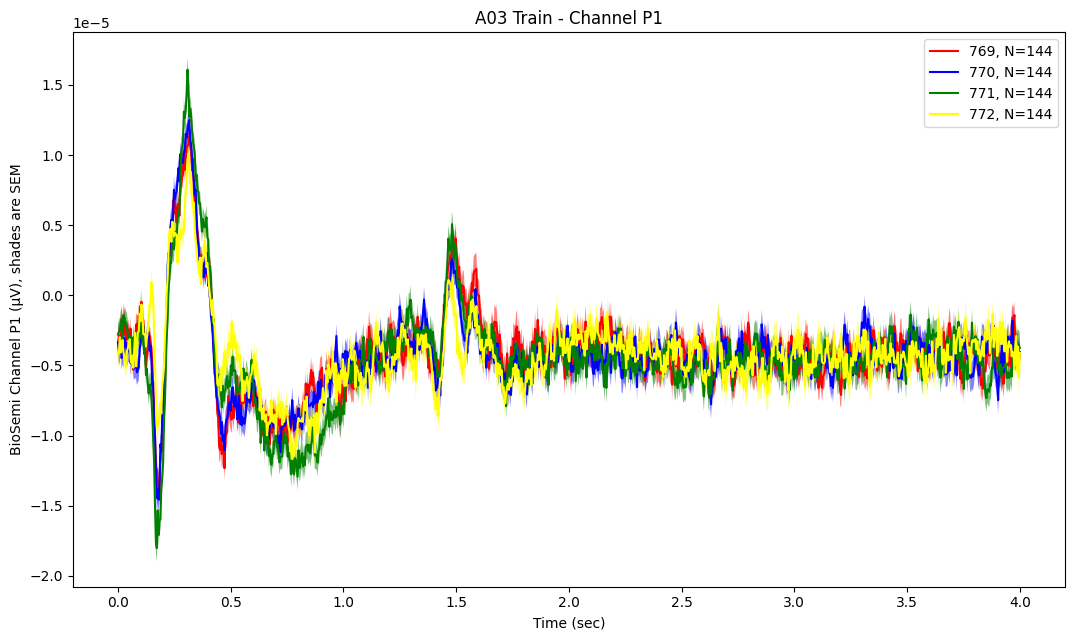

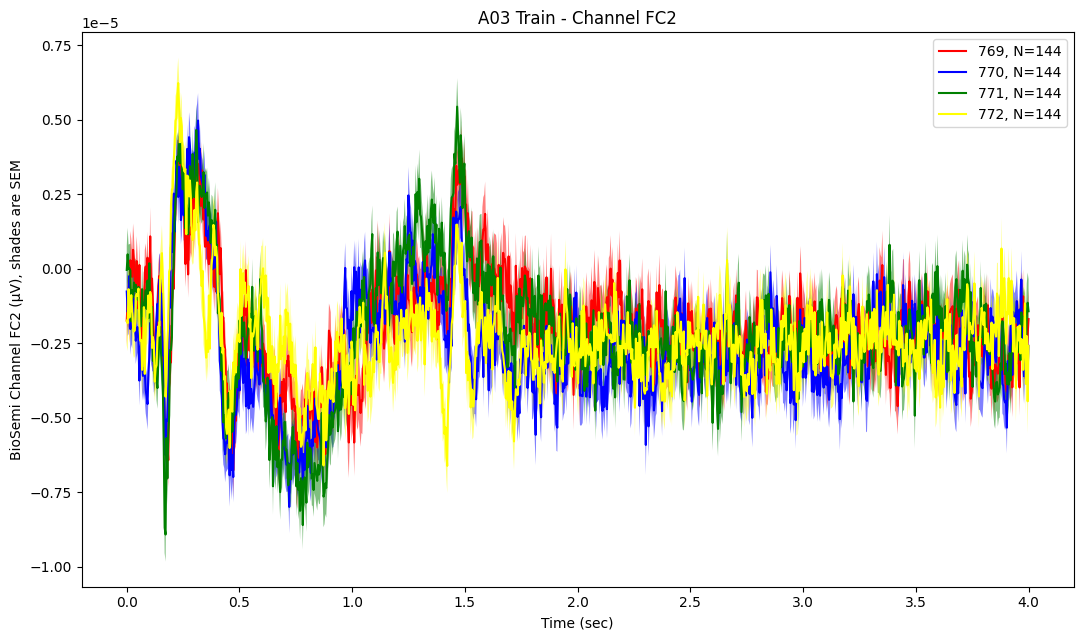

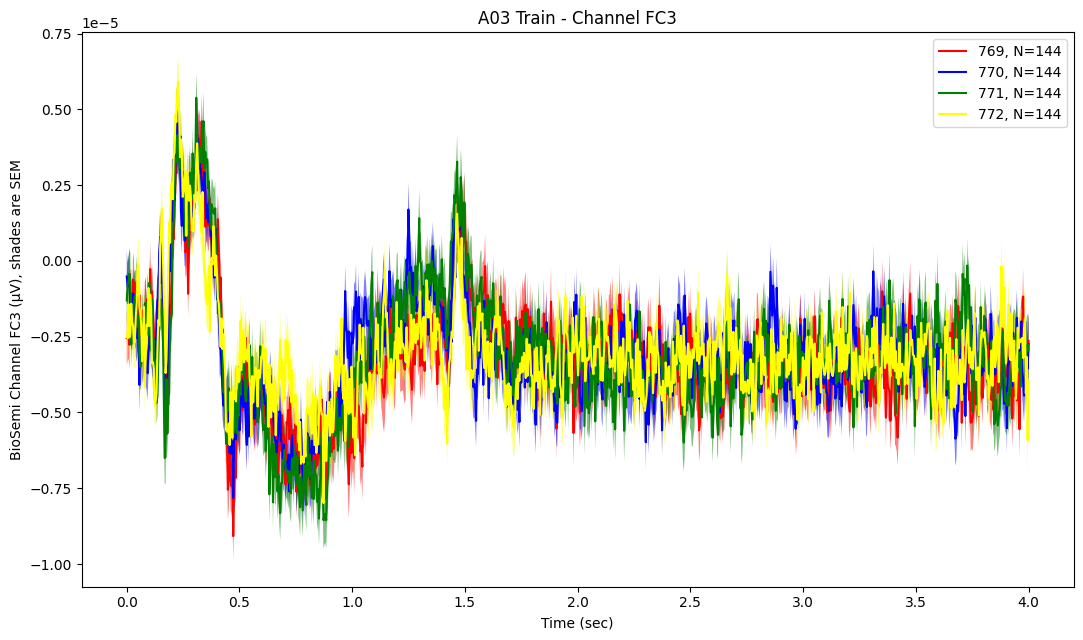

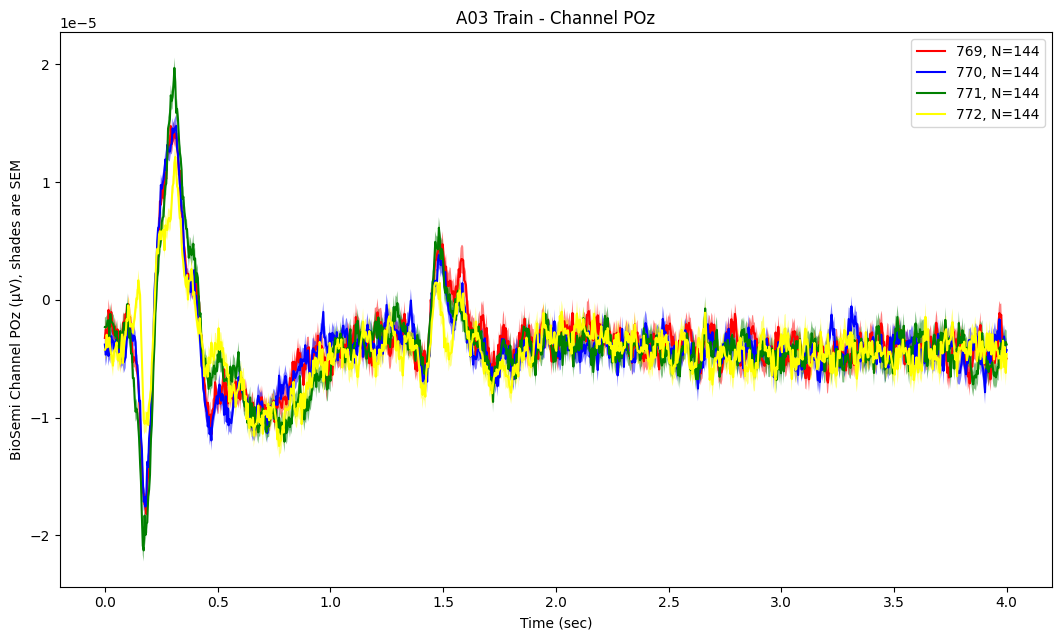

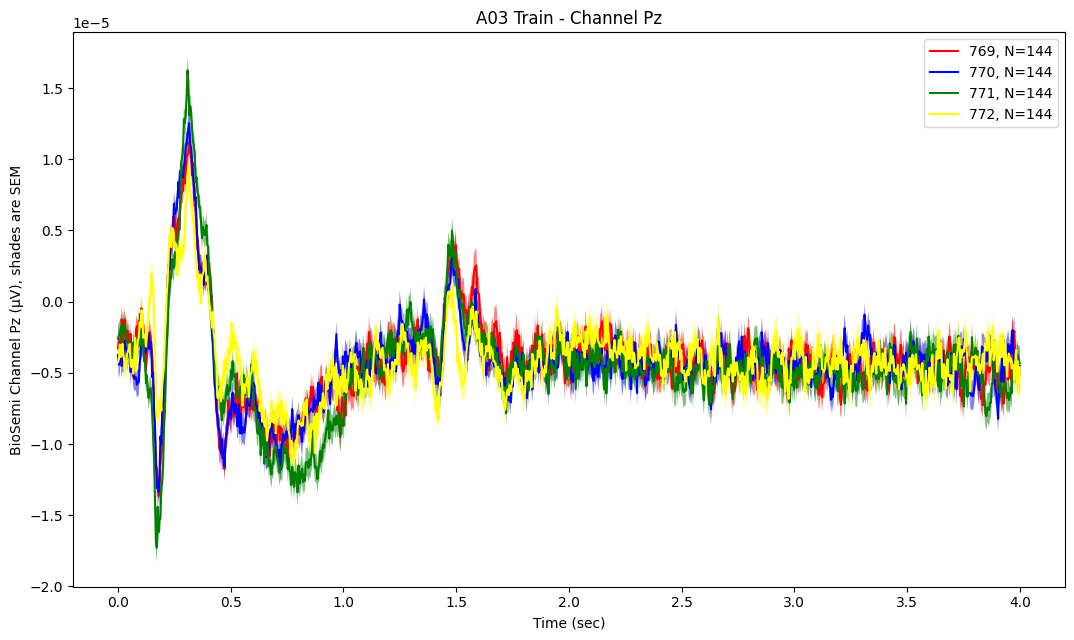

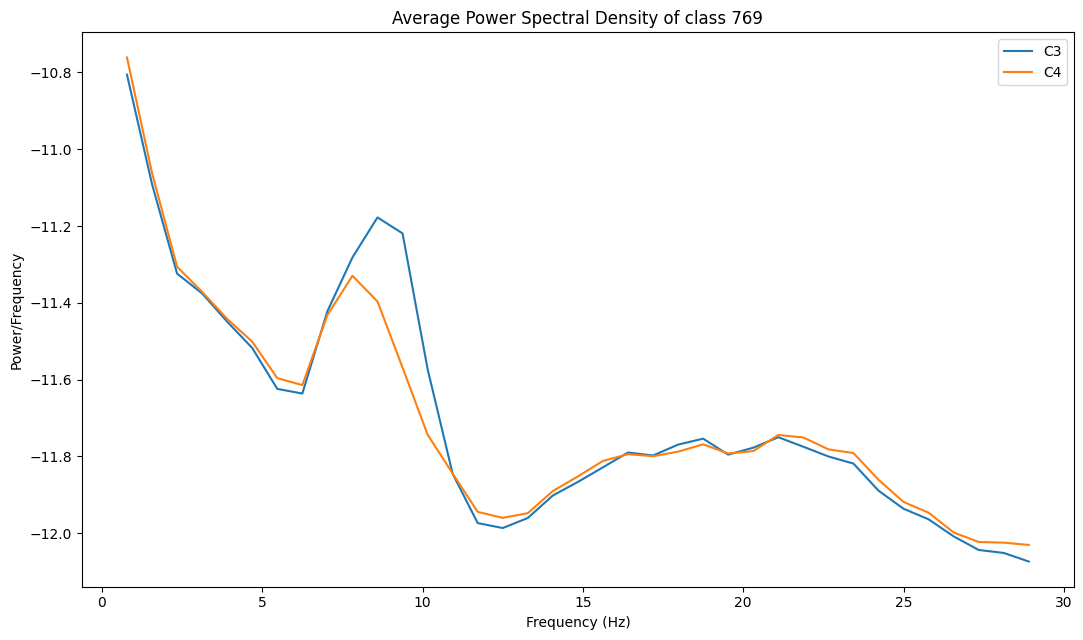

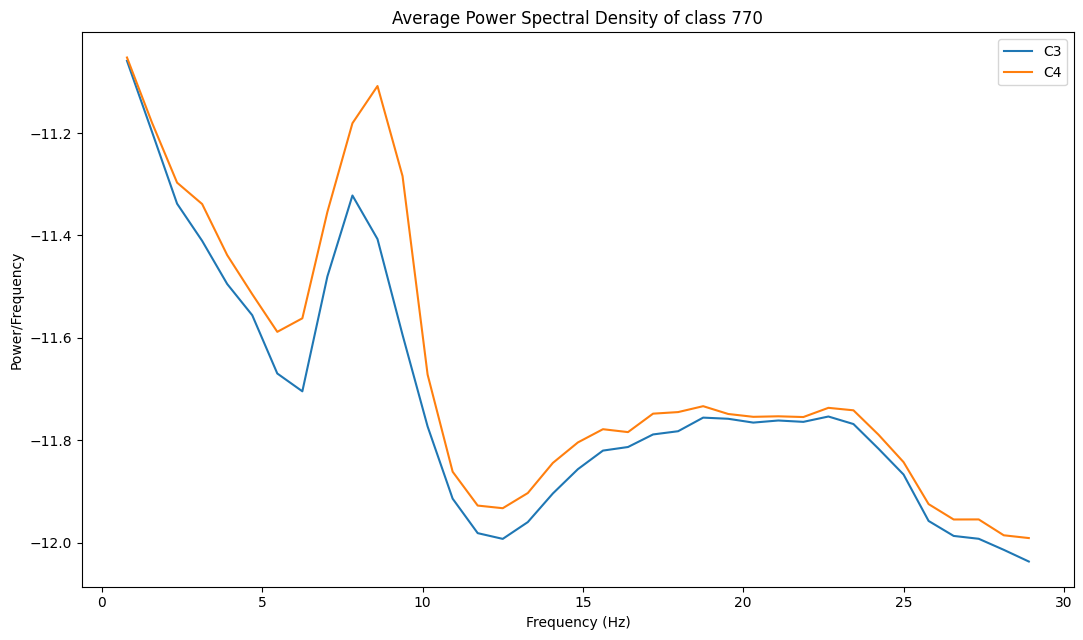

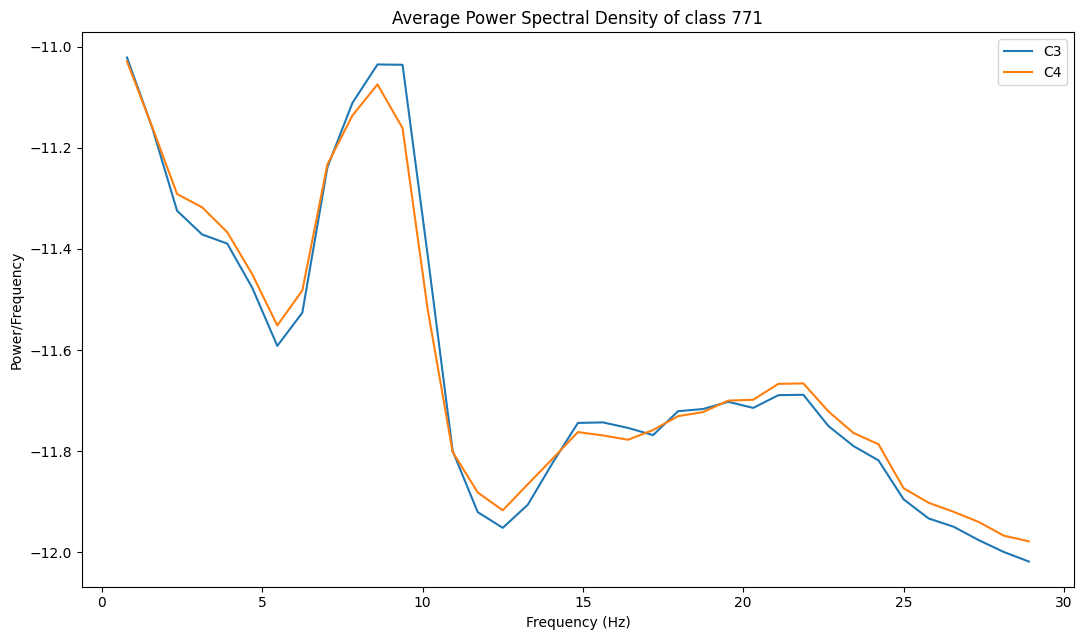

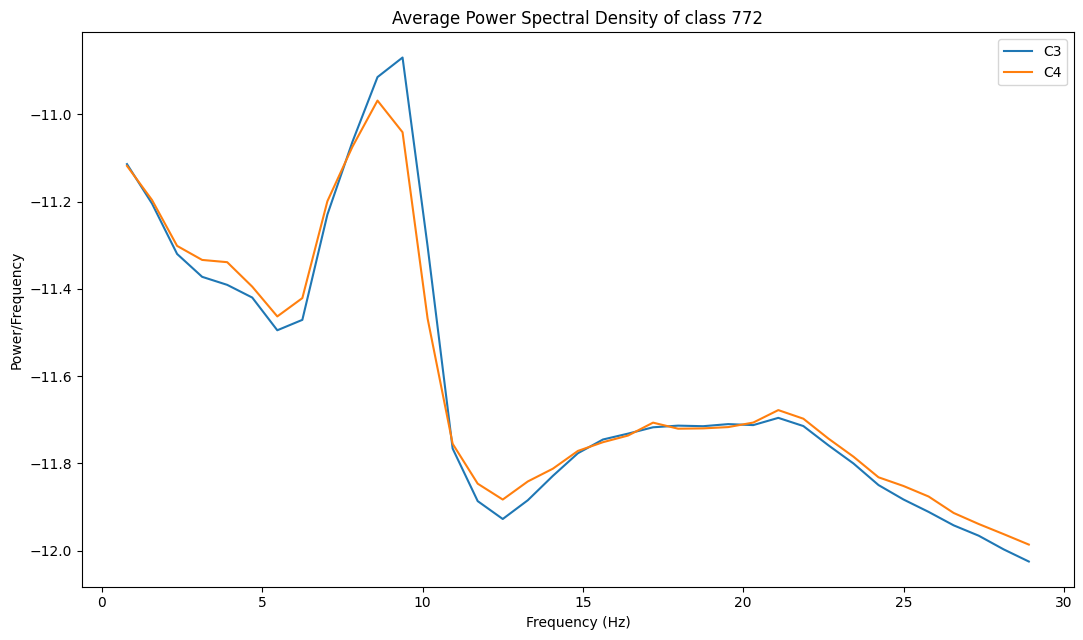

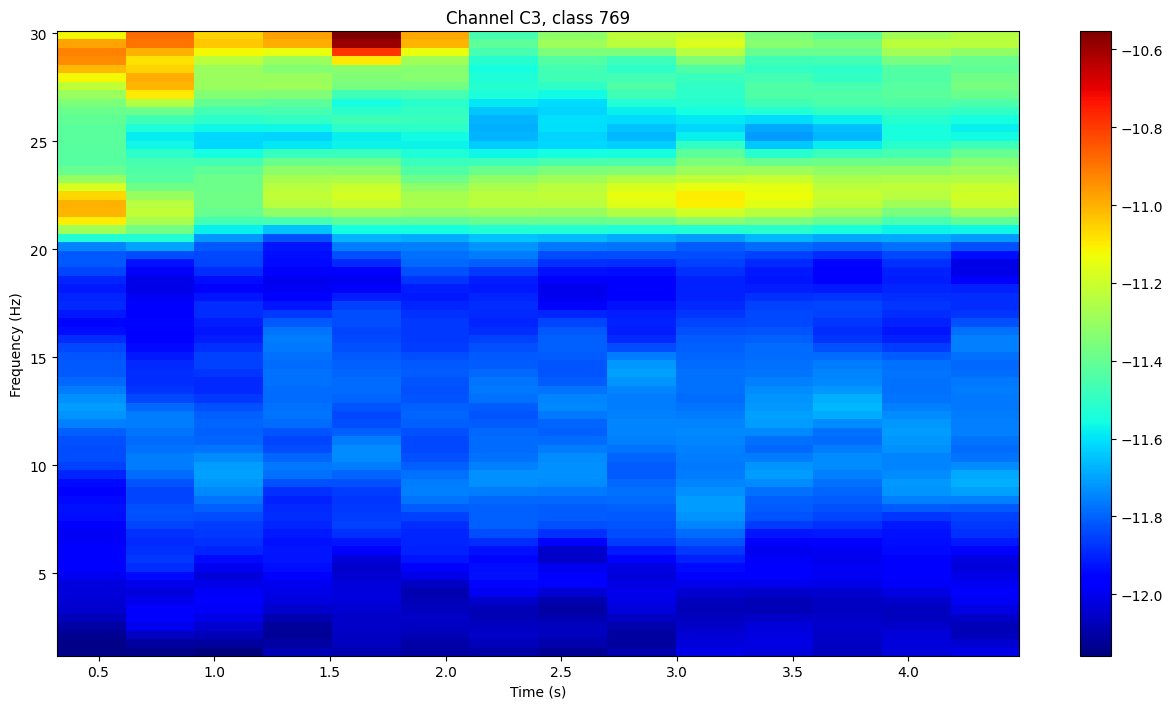

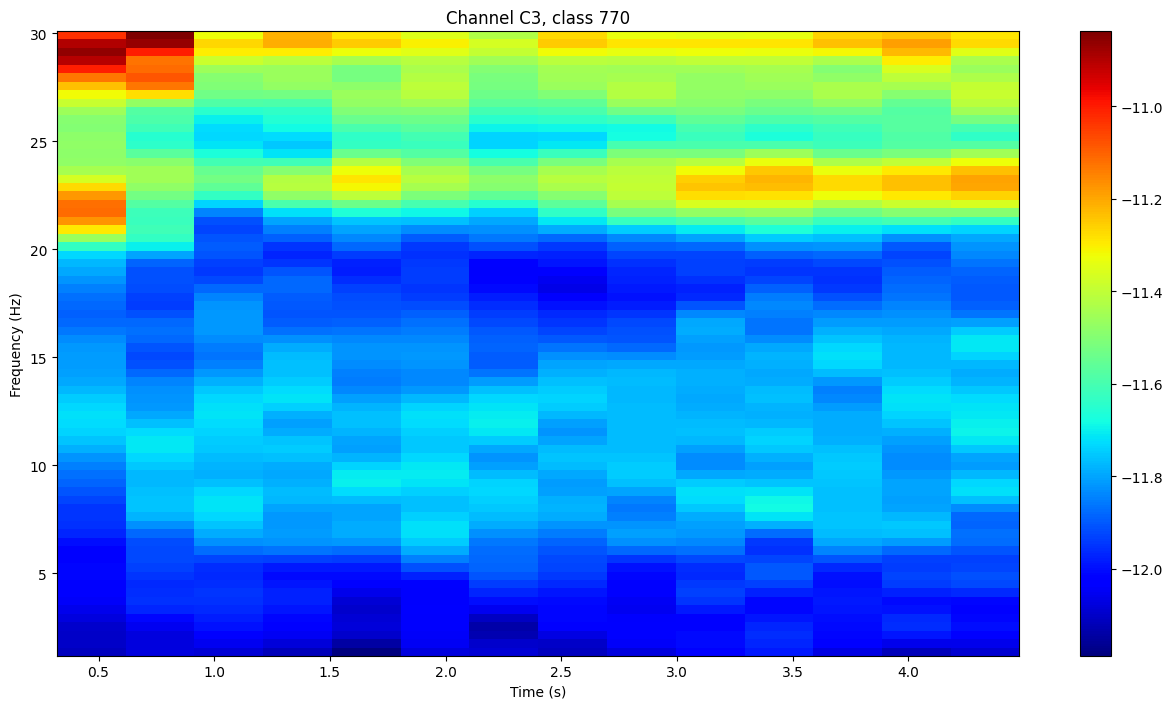

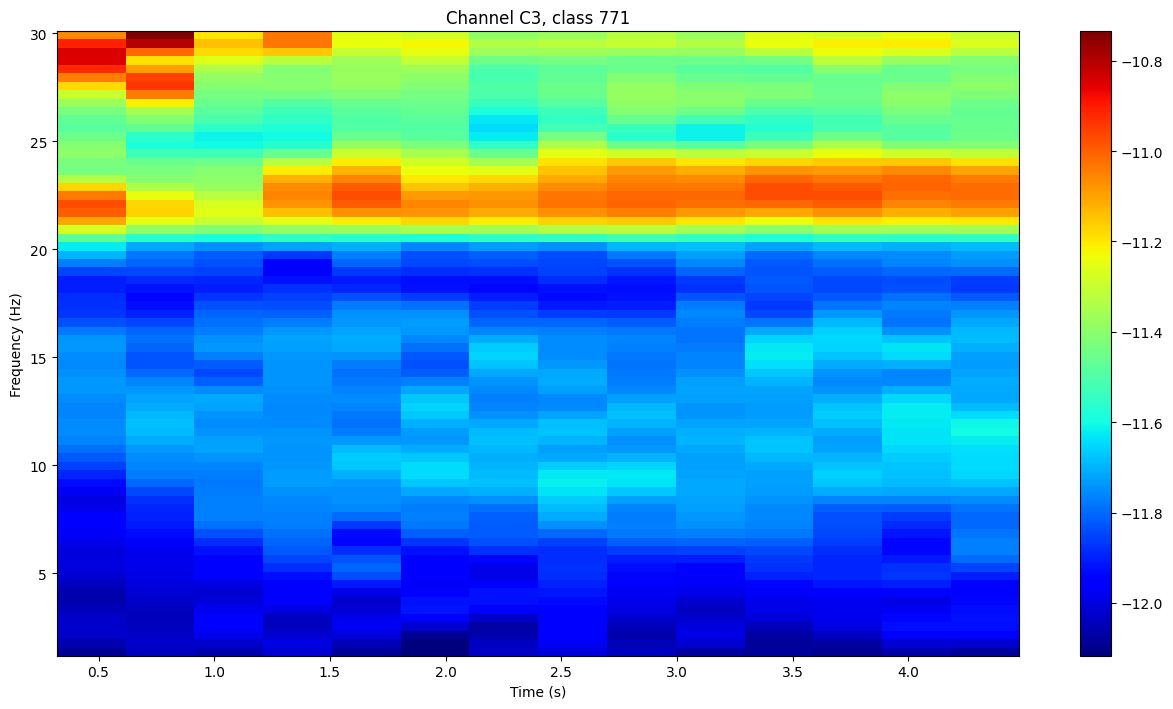

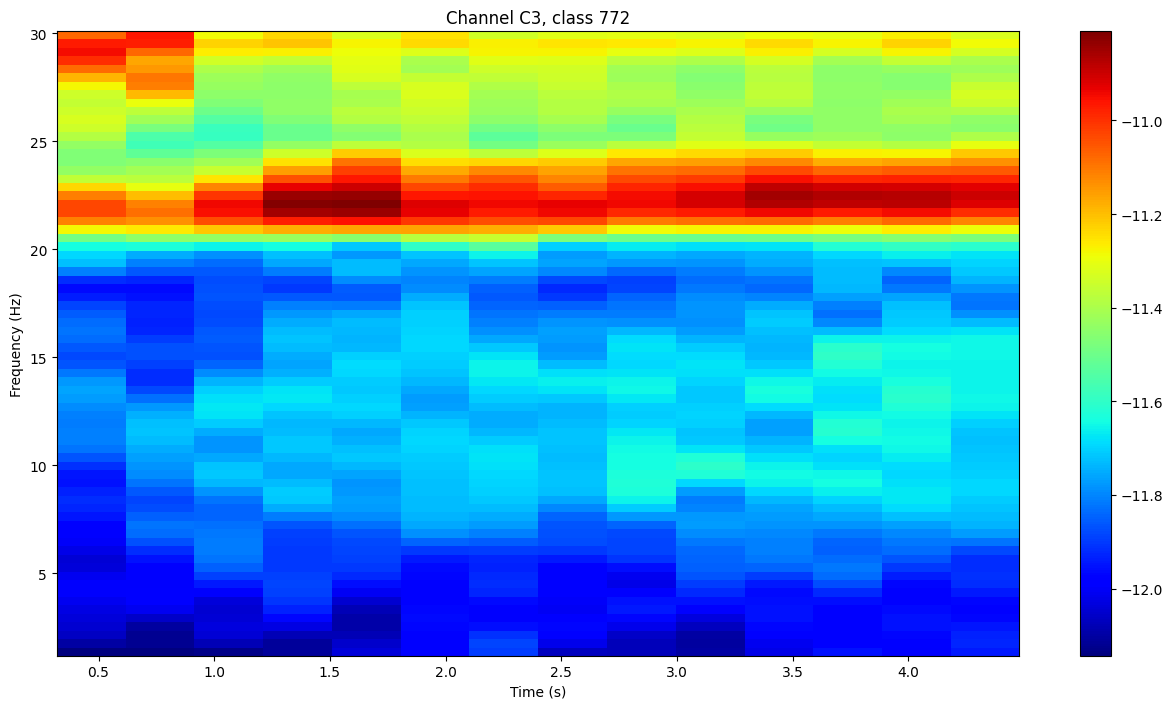

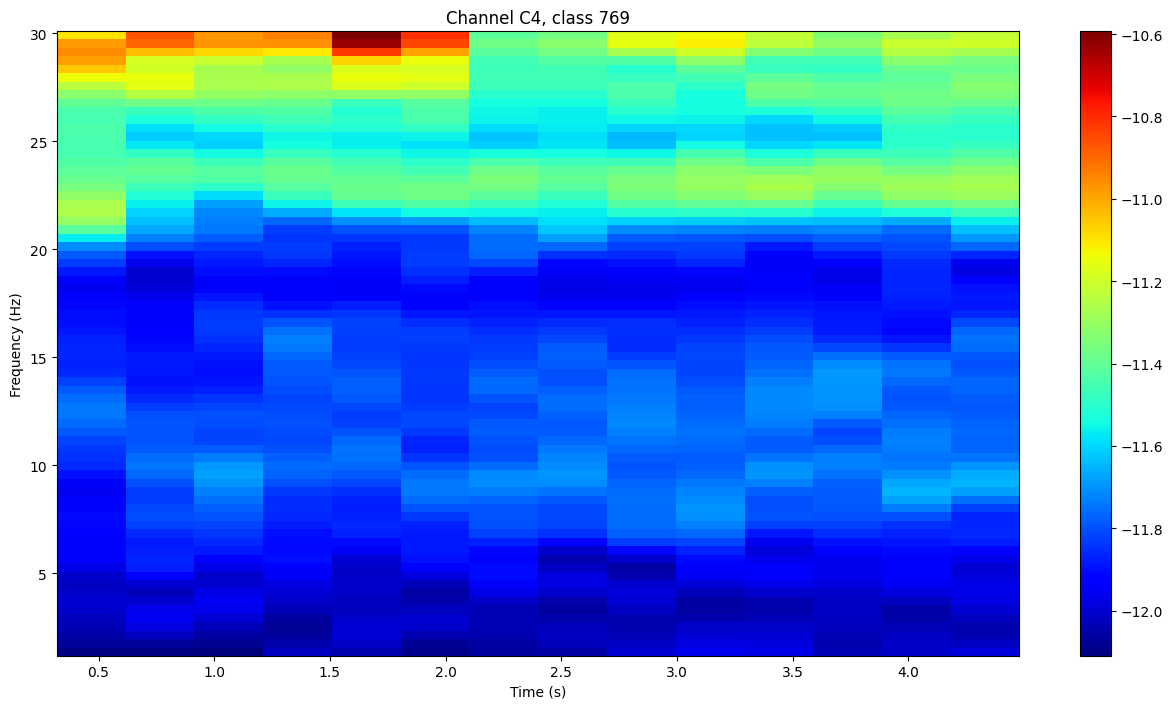

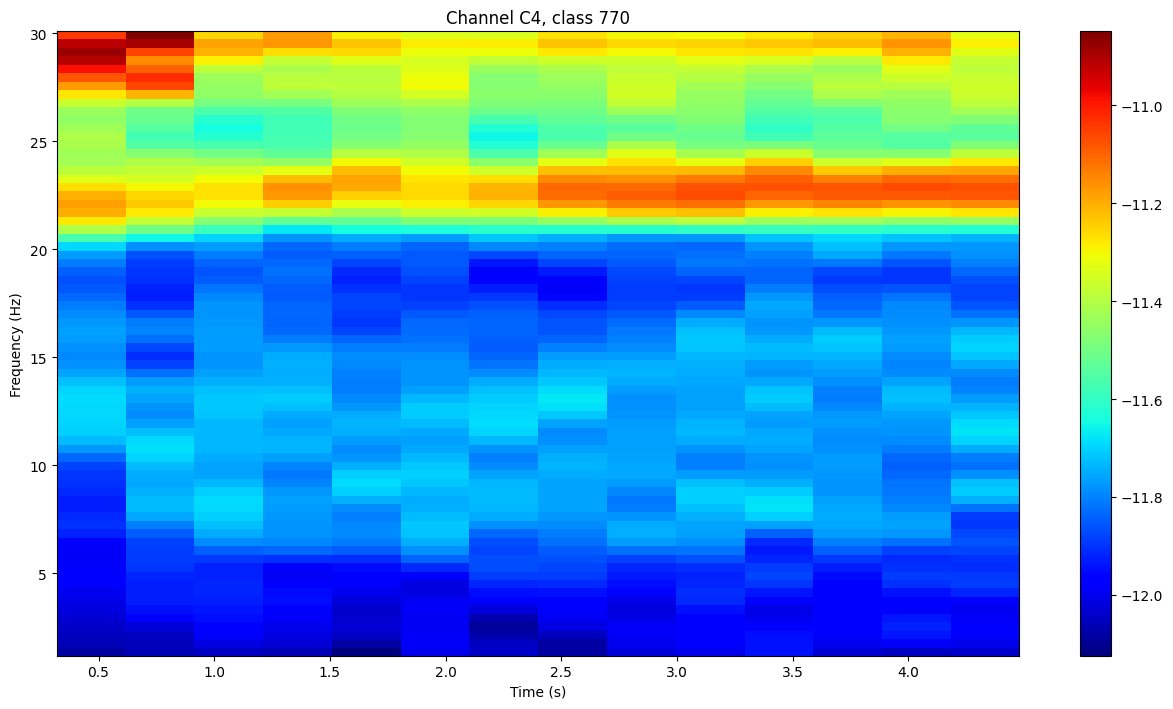

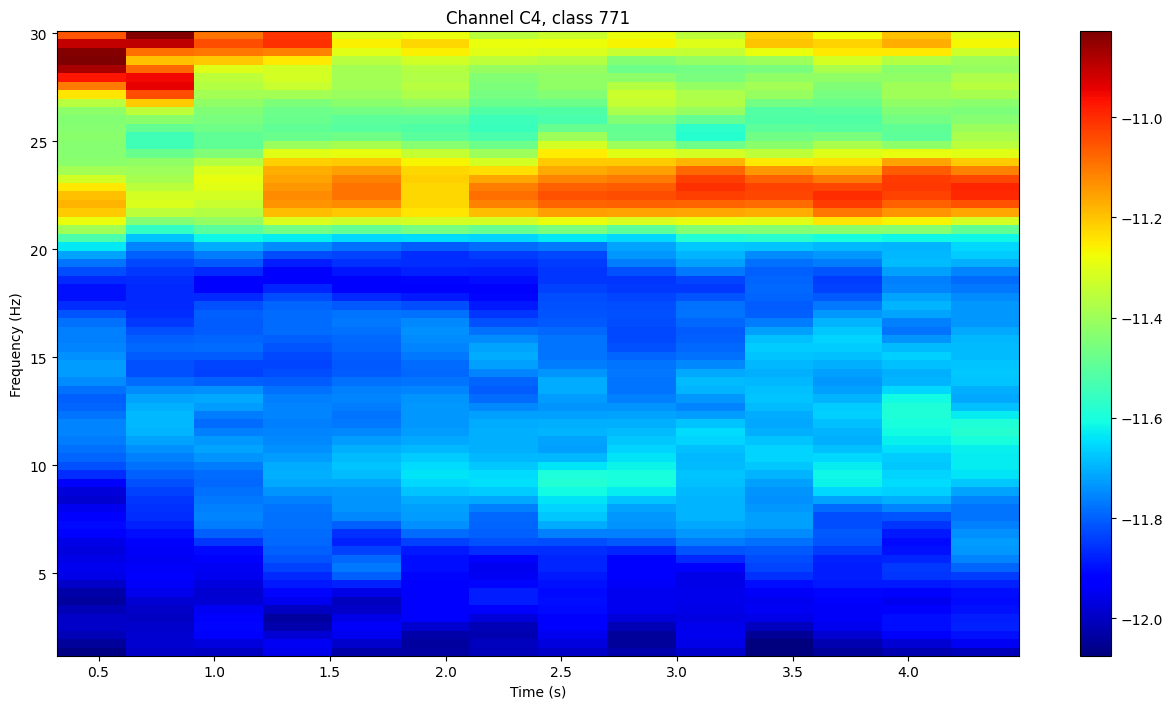

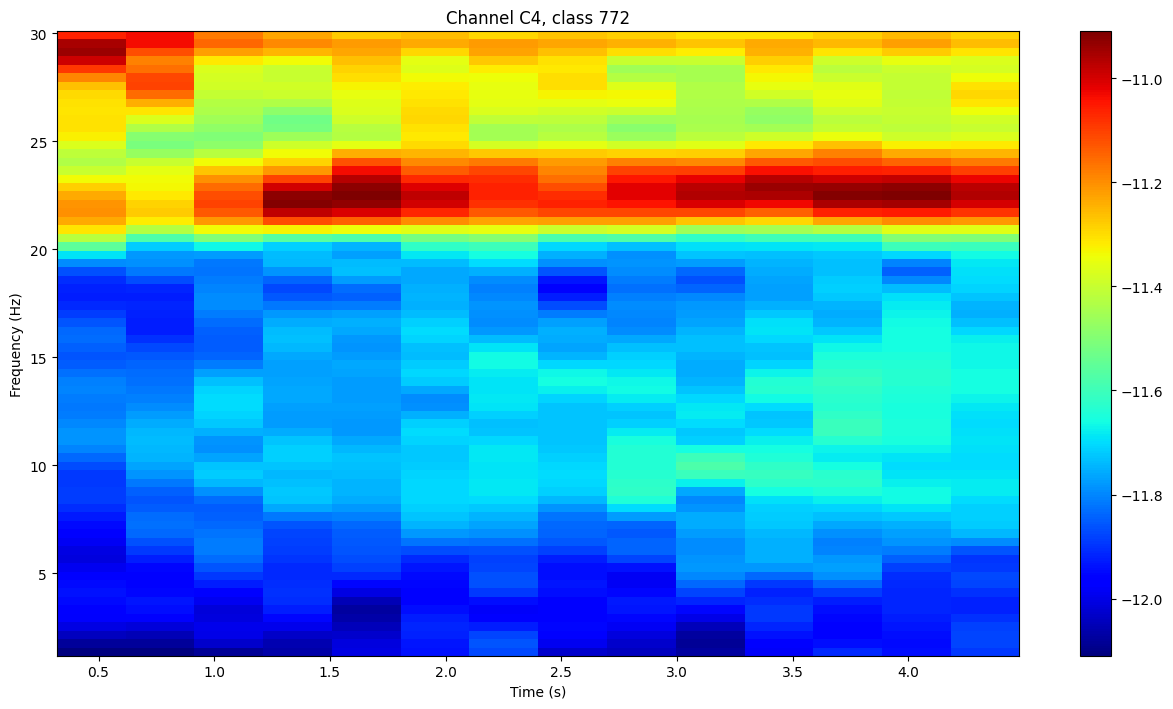

In [5]:
# train_path = os.path.join(data_root, f'{subject}T.mat')
# eval_path = os.path.join(data_root, f'{subject}E.mat')
# 
# train_epochs = load_mat_sessions(train_path, f'{subject} Train')
# eval_epochs = load_mat_sessions(eval_path, f'{subject} Eval')
# 
train_path = os.path.join(data_root, f'{subject}T.gdf')
eval_path = os.path.join(data_root, f'{subject}E.gdf')

train_epochs, eval_epochs= load_gdf_sessions(train_path, eval_path, f'{subject} Train')

In [6]:
class PatchEmbedding(nn.Module):
    def __init__(self, emb_size=40):
        # self.patch_size = patch_size
        super().__init__()

        self.shallownet = nn.Sequential(
            nn.Conv2d(1, 40, (1, 25), (1, 1)),
            nn.Conv2d(40, 40, (22, 1), (1, 1)),
            nn.BatchNorm2d(40),
            nn.ELU(),
            nn.AvgPool2d((1, 75), (1, 15)),  # pooling acts as slicing to obtain 'patch' along the time dimension as in ViT
            nn.Dropout(0.5),
        )

        self.projection = nn.Sequential(
            nn.Conv2d(40, emb_size, (1, 1), stride=(1, 1)),  # transpose, conv could enhance fiting ability slightly
            Rearrange('b e (h) (w) -> b (h w) e'),
        )


    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.shallownet(x)
        x = self.projection(x)
        return x


class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size, num_heads, dropout):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.keys = nn.Linear(emb_size, emb_size)
        self.queries = nn.Linear(emb_size, emb_size)
        self.values = nn.Linear(emb_size, emb_size)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x: Tensor, mask: Tensor = None) -> Tensor:
        queries = rearrange(self.queries(x), "b n (h d) -> b h n d", h=self.num_heads)
        keys = rearrange(self.keys(x), "b n (h d) -> b h n d", h=self.num_heads)
        values = rearrange(self.values(x), "b n (h d) -> b h n d", h=self.num_heads)
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys)  
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)

        scaling = self.emb_size ** (1 / 2)
        att = F.softmax(energy / scaling, dim=-1)
        att = self.att_drop(att)
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out


class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x


class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size, expansion, drop_p):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )


class GELU(nn.Module):
    def forward(self, input: Tensor) -> Tensor:
        return input*0.5*(1.0+torch.erf(input/math.sqrt(2.0)))


class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size,
                 num_heads=10,
                 drop_p=0.5,
                 forward_expansion=4,
                 forward_drop_p=0.5):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, num_heads, drop_p),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))


class TransformerEncoder(nn.Sequential):
    def __init__(self, depth, emb_size):
        super().__init__(*[TransformerEncoderBlock(emb_size) for _ in range(depth)])


class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size, n_classes):
        super().__init__()
        
        # global average pooling
        self.clshead = nn.Sequential(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, n_classes)
        )
        self.fc = nn.Sequential(
            nn.Linear(2440, 256),
            nn.ELU(),
            nn.Dropout(0.5),
            nn.Linear(256, 32),
            nn.ELU(),
            nn.Dropout(0.3),
            nn.Linear(32, 4)
        )

    def forward(self, x):
        x = x.contiguous().view(x.size(0), -1)
        out = self.fc(x)
        return x, out


class Conformer(nn.Sequential):
    def __init__(self, emb_size=40, depth=6, n_classes=4, **kwargs):
        super().__init__(

            PatchEmbedding(emb_size),
            TransformerEncoder(depth, emb_size),
            ClassificationHead(emb_size, n_classes)
        )

In [7]:
batch_size = 72
n_epochs = 2000
c_dim = 4
lr = 0.0002
b1 = 0.5
b2 = 0.999
dimension = (190, 50)

model = Conformer().cuda()
model = model.cuda()

criterion_l1 = torch.nn.L1Loss().cuda()
criterion_l2 = torch.nn.MSELoss().cuda()
criterion_cls = torch.nn.CrossEntropyLoss().cuda()

## Prepare the data

In [8]:
train_data = train_epochs.get_data().copy()
train_data = np.expand_dims(train_data, axis=1)

train_label = train_epochs.events[:, -1]
shuffle_num = np.random.permutation(len(train_data))

train_data = train_data[shuffle_num, :, :, :]
train_label = train_label[shuffle_num]

test_data = eval_epochs.get_data().copy()
test_data = np.expand_dims(test_data, axis=1)
test_label = eval_epochs.events[:, -1]

target_mean = np.mean(train_data)
target_std = np.std(train_data)
train_data = (train_data - target_mean) / target_std
test_data = (test_data - target_mean) / target_std

In [9]:
train_data = torch.from_numpy(train_data)
train_label = torch.from_numpy(train_label)
dataset = TensorDataset(train_data, train_label)
train_dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

test_data = torch.from_numpy(test_data)
test_label = torch.from_numpy(test_label )
test_dataset = torch.utils.data.TensorDataset(test_data, test_label)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(b1, b2))


In [10]:

def interaug(timg, label):  
    aug_data = []
    aug_label = []
    for cls4aug in range(4):
        cls_idx = np.where(label == cls4aug)
        tmp_data = timg[cls_idx]
        tmp_label = label[cls_idx]

        tmp_aug_data = np.zeros((int(batch_size / 4), 1, 22, 1000))
        for ri in range(int(batch_size / 4)):
            for rj in range(8):
                rand_idx = np.random.randint(0, tmp_data.shape[0], 8)
                tmp_aug_data[ri, :, :, rj * 125:(rj + 1) * 125] = tmp_data[rand_idx[rj], :, :,
                                                                  rj * 125:(rj + 1) * 125]

        aug_data.append(tmp_aug_data)
        aug_label.append(tmp_label[:int(batch_size / 4)])
    aug_data = np.concatenate(aug_data)
    aug_label = np.concatenate(aug_label)
    aug_shuffle = np.random.permutation(len(aug_data))
    aug_data = aug_data[aug_shuffle, :, :]
    aug_label = aug_label[aug_shuffle]

    aug_data = torch.from_numpy(aug_data).cuda()
    aug_data = aug_data.float()
    aug_label = torch.from_numpy(aug_label-1).cuda()
    aug_label = aug_label.long()
    return aug_data, aug_label

In [11]:
bestAcc = 0
averAcc = 0
num = 0
Y_true = 0
Y_pred = 0

# Train the cnn model
total_step = len(train_dataloader)
curr_lr = lr

for e in range(n_epochs):
    # in_epoch = time.time()
    model.train()
    for i, (img, label) in enumerate(train_dataloader):

        img = img.cuda().float()
        label = label.cuda().long()

        # data augmentation
        aug_data, aug_label = interaug(train_data, train_label)
        img = torch.cat((img, aug_data))
        label = torch.cat((label, aug_label))
        tok, outputs = model(img)
        break
    break
#         loss = criterion_cls(outputs, label) 
# 
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
# 
#     # test process
#     if (e + 1) % 1 == 0:
#         model.eval()
#         Tok, Cls = model(test_data)
# 
#         loss_test = criterion_cls(Cls, test_label)
#         y_pred = torch.max(Cls, 1)[1]
#         acc = float((y_pred == test_label).cpu().numpy().astype(int).sum()) / float(test_label.size(0))
#         train_pred = torch.max(outputs, 1)[1]
#         train_acc = float((train_pred == label).cpu().numpy().astype(int).sum()) / float(label.size(0))
# 
#         print('Epoch:', e,
#               '  Train loss: %.6f' % loss.detach().cpu().numpy(),
#               '  Test loss: %.6f' % loss_test.detach().cpu().numpy(),
#               '  Train accuracy %.6f' % train_acc,
#               '  Test accuracy is %.6f' % acc)
# 
#         num = num + 1
#         averAcc = averAcc + acc
#         if acc > bestAcc:
#             bestAcc = acc
#             Y_true = test_label
#             Y_pred = y_pred
# 
# averAcc = averAcc / num
# print('The average accuracy is:', averAcc)
# print('The best accuracy is:', bestAcc)

In [12]:
loss = nn.CrossEntropyLoss()(outputs, label) 


In [11]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = []
    num_correct_preds = 0
    pbar = tqdm(total=len(train_dataloader), desc=f'Epoch {epoch+1}/{num_epochs} training', unit="batch")
    for x, y in train_dataloader:
        y_tensor = y.to(device)
        # Forward pass
        outputs = model(x.to(device))
        y_pred = last_activation(outputs)
        loss = criterion(y_pred, y_tensor)
        l2_penalty = l2_weight * sum([(p ** 2).sum() for p in model.parameters()])
        loss += l2_penalty
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss.append(loss.item())

        # Calculate training predictions for accuracy calculation
        preds = torch.argmax(y_pred, dim=1).detach().cpu().numpy()

        predicted_labels = torch.argmax(y_pred, dim=1)
        true_label = torch.argmax(y_tensor, dim=1)
        num_correct_preds += torch.sum(true_label == predicted_labels).item()

        # Update progress bar description with loss
        pbar.update(1)
        pbar.set_postfix(loss=loss.item())
    pbar.close()
    scheduler.step()

    # Compute the average training loss for the epoch
    avg_loss = np.mean(running_loss)

    # Calculate training accuracy
    train_acc = num_correct_preds / len(train_dataset)

    # Evaluate on the validation set
    model.eval()
    val_running_loss = []
    num_correct_preds = 0
    val_preds = []
    with torch.no_grad():
        pbar = tqdm(total=len(val_dataloader), desc=f'Epoch {epoch + 1}/{num_epochs} validating', unit="batch")
        for x, y in val_dataloader:
            y_tensor = y.to(device)
            # Forward pass
            y_pred_prelogits = model(x.to(device))
            y_pred_postlogits = last_activation(y_pred_prelogits)
            loss = criterion(y_pred_prelogits, y_tensor)

            val_running_loss.append(loss.item())

            # Calculate training predictions for accuracy calculation
            predicted_labels = torch.argmax(y_pred_postlogits, dim=1)
            true_label = torch.argmax(y_tensor, dim=1)
            num_correct_preds += torch.sum(true_label == predicted_labels).item()

            # Update progress bar description with loss
            pbar.update(1)
            pbar.set_postfix(loss=loss.item())
    pbar.close()

    # Compute the average validation loss
    val_avg_loss = np.mean(val_running_loss)
    # Calculate validation accuracy
    val_acc = num_correct_preds / len(val_dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_avg_loss:.4f}, Val Acc: {val_acc:.4f}")

print("Training finished!")

# torch.save(model.state_dict(), file_path)

Epoch 1/100 validating: 100%|██████████| 9/9 [00:00<00:00, 254.25batch/s, loss=1.4] 


Epoch [1/100], Train Loss: 1.3939, Train Acc: 0.2500, Val Loss: 1.3898, Val Acc: 0.2500


Epoch 2/100 validating: 100%|██████████| 9/9 [00:00<00:00, 321.43batch/s, loss=1.39]


Epoch [2/100], Train Loss: 1.3926, Train Acc: 0.2500, Val Loss: 1.3896, Val Acc: 0.2500


Epoch 3/100 validating: 100%|██████████| 9/9 [00:00<00:00, 327.27batch/s, loss=1.4] 


Epoch [3/100], Train Loss: 1.3911, Train Acc: 0.2500, Val Loss: 1.3891, Val Acc: 0.2500


Epoch 4/100 validating: 100%|██████████| 9/9 [00:00<00:00, 339.61batch/s, loss=1.37]


Epoch [4/100], Train Loss: 1.3888, Train Acc: 0.2500, Val Loss: 1.3877, Val Acc: 0.2500


Epoch 5/100 validating: 100%|██████████| 9/9 [00:00<00:00, 305.11batch/s, loss=1.39]


Epoch [5/100], Train Loss: 1.3850, Train Acc: 0.2535, Val Loss: 1.3856, Val Acc: 0.2500


Epoch 6/100 validating: 100%|██████████| 9/9 [00:00<00:00, 300.03batch/s, loss=1.41]


Epoch [6/100], Train Loss: 1.3786, Train Acc: 0.2951, Val Loss: 1.3814, Val Acc: 0.2500


Epoch 7/100 validating: 100%|██████████| 9/9 [00:00<00:00, 272.72batch/s, loss=1.39]


Epoch [7/100], Train Loss: 1.3687, Train Acc: 0.4028, Val Loss: 1.3755, Val Acc: 0.2500


Epoch 8/100 validating: 100%|██████████| 9/9 [00:00<00:00, 290.34batch/s, loss=1.39]


Epoch [8/100], Train Loss: 1.3521, Train Acc: 0.4340, Val Loss: 1.3677, Val Acc: 0.2500


Epoch 9/100 validating: 100%|██████████| 9/9 [00:00<00:00, 321.41batch/s, loss=1.35]


Epoch [9/100], Train Loss: 1.3251, Train Acc: 0.4896, Val Loss: 1.3615, Val Acc: 0.2569


Epoch 10/100 validating: 100%|██████████| 9/9 [00:00<00:00, 339.65batch/s, loss=1.39]


Epoch [10/100], Train Loss: 1.2866, Train Acc: 0.7083, Val Loss: 1.3558, Val Acc: 0.2708


Epoch 11/100 validating: 100%|██████████| 9/9 [00:00<00:00, 315.77batch/s, loss=1.24]


Epoch [11/100], Train Loss: 1.2401, Train Acc: 0.7951, Val Loss: 1.3437, Val Acc: 0.3160


Epoch 12/100 validating: 100%|██████████| 9/9 [00:00<00:00, 333.31batch/s, loss=1.24]


Epoch [12/100], Train Loss: 1.1893, Train Acc: 0.9062, Val Loss: 1.3771, Val Acc: 0.2951


Epoch 13/100 validating: 100%|██████████| 9/9 [00:00<00:00, 310.31batch/s, loss=1.27]


Epoch [13/100], Train Loss: 1.1395, Train Acc: 0.9132, Val Loss: 1.3216, Val Acc: 0.3681


Epoch 14/100 validating: 100%|██████████| 9/9 [00:00<00:00, 321.44batch/s, loss=1.34]


Epoch [14/100], Train Loss: 1.0878, Train Acc: 0.9618, Val Loss: 1.3518, Val Acc: 0.3438


Epoch 15/100 validating: 100%|██████████| 9/9 [00:00<00:00, 321.45batch/s, loss=1.36]


Epoch [15/100], Train Loss: 1.0405, Train Acc: 0.9826, Val Loss: 1.3338, Val Acc: 0.3958


Epoch 16/100 validating: 100%|██████████| 9/9 [00:00<00:00, 339.59batch/s, loss=1.34]


Epoch [16/100], Train Loss: 0.9979, Train Acc: 0.9861, Val Loss: 1.3499, Val Acc: 0.3819


Epoch 17/100 validating: 100%|██████████| 9/9 [00:00<00:00, 327.25batch/s, loss=1.46]


Epoch [17/100], Train Loss: 0.9572, Train Acc: 1.0000, Val Loss: 1.3508, Val Acc: 0.3924


Epoch 18/100 validating: 100%|██████████| 9/9 [00:00<00:00, 327.31batch/s, loss=1.38]


Epoch [18/100], Train Loss: 0.9264, Train Acc: 1.0000, Val Loss: 1.3596, Val Acc: 0.3819


Epoch 19/100 validating: 100%|██████████| 9/9 [00:00<00:00, 333.33batch/s, loss=1.4] 


Epoch [19/100], Train Loss: 0.8975, Train Acc: 1.0000, Val Loss: 1.3886, Val Acc: 0.3715


Epoch 20/100 validating: 100%|██████████| 9/9 [00:00<00:00, 281.27batch/s, loss=1.39]


Epoch [20/100], Train Loss: 0.8751, Train Acc: 1.0000, Val Loss: 1.3953, Val Acc: 0.3854


Epoch 21/100 validating: 100%|██████████| 9/9 [00:00<00:00, 310.33batch/s, loss=1.26]


Epoch [21/100], Train Loss: 0.8576, Train Acc: 1.0000, Val Loss: 1.4106, Val Acc: 0.3750


Epoch 22/100 validating: 100%|██████████| 9/9 [00:00<00:00, 315.79batch/s, loss=1.61]


Epoch [22/100], Train Loss: 0.8443, Train Acc: 1.0000, Val Loss: 1.4272, Val Acc: 0.3854


Epoch 23/100 validating: 100%|██████████| 9/9 [00:00<00:00, 315.77batch/s, loss=1.48]


Epoch [23/100], Train Loss: 0.8332, Train Acc: 1.0000, Val Loss: 1.4429, Val Acc: 0.3750


Epoch 24/100 validating: 100%|██████████| 9/9 [00:00<00:00, 339.62batch/s, loss=1.39]


Epoch [24/100], Train Loss: 0.8251, Train Acc: 1.0000, Val Loss: 1.4565, Val Acc: 0.3750


Epoch 25/100 validating: 100%|██████████| 9/9 [00:00<00:00, 333.23batch/s, loss=1.35]


Epoch [25/100], Train Loss: 0.8178, Train Acc: 1.0000, Val Loss: 1.4739, Val Acc: 0.3854


Epoch 26/100 validating: 100%|██████████| 9/9 [00:00<00:00, 295.07batch/s, loss=1.7]  


Epoch [26/100], Train Loss: 0.8121, Train Acc: 1.0000, Val Loss: 1.4753, Val Acc: 0.3646


Epoch 27/100 validating: 100%|██████████| 9/9 [00:00<00:00, 290.31batch/s, loss=1.21]


Epoch [27/100], Train Loss: 0.8070, Train Acc: 1.0000, Val Loss: 1.4891, Val Acc: 0.3681


Epoch 28/100 validating: 100%|██████████| 9/9 [00:00<00:00, 268.66batch/s, loss=1.15]


Epoch [28/100], Train Loss: 0.8034, Train Acc: 1.0000, Val Loss: 1.5067, Val Acc: 0.3785


Epoch 29/100 validating: 100%|██████████| 9/9 [00:00<00:00, 310.35batch/s, loss=1.42]


Epoch [29/100], Train Loss: 0.8010, Train Acc: 1.0000, Val Loss: 1.5096, Val Acc: 0.3715


Epoch 30/100 validating: 100%|██████████| 9/9 [00:00<00:00, 346.19batch/s, loss=1.21]


Epoch [30/100], Train Loss: 0.7977, Train Acc: 1.0000, Val Loss: 1.5138, Val Acc: 0.3715


Epoch 31/100 validating: 100%|██████████| 9/9 [00:00<00:00, 263.26batch/s, loss=1.4] 


Epoch [31/100], Train Loss: 0.7969, Train Acc: 1.0000, Val Loss: 1.5219, Val Acc: 0.3681


Epoch 32/100 validating: 100%|██████████| 9/9 [00:00<00:00, 321.44batch/s, loss=1.59]


Epoch [32/100], Train Loss: 0.7944, Train Acc: 1.0000, Val Loss: 1.5279, Val Acc: 0.3715


Epoch 33/100 validating: 100%|██████████| 9/9 [00:00<00:00, 315.77batch/s, loss=1.27]


Epoch [33/100], Train Loss: 0.7925, Train Acc: 1.0000, Val Loss: 1.5333, Val Acc: 0.3715


Epoch 34/100 validating: 100%|██████████| 9/9 [00:00<00:00, 321.44batch/s, loss=1.71]


Epoch [34/100], Train Loss: 0.7914, Train Acc: 1.0000, Val Loss: 1.5425, Val Acc: 0.3715


Epoch 35/100 validating: 100%|██████████| 9/9 [00:00<00:00, 321.44batch/s, loss=1.53]


Epoch [35/100], Train Loss: 0.7898, Train Acc: 1.0000, Val Loss: 1.5452, Val Acc: 0.3750


Epoch 36/100 validating: 100%|██████████| 9/9 [00:00<00:00, 300.00batch/s, loss=2.06]


Epoch [36/100], Train Loss: 0.7890, Train Acc: 1.0000, Val Loss: 1.5509, Val Acc: 0.3750


Epoch 37/100 validating: 100%|██████████| 9/9 [00:00<00:00, 299.99batch/s, loss=1.39]


Epoch [37/100], Train Loss: 0.7882, Train Acc: 1.0000, Val Loss: 1.5515, Val Acc: 0.3750


Epoch 38/100 validating: 100%|██████████| 9/9 [00:00<00:00, 333.30batch/s, loss=1.54]


Epoch [38/100], Train Loss: 0.7869, Train Acc: 1.0000, Val Loss: 1.5548, Val Acc: 0.3750


Epoch 39/100 validating: 100%|██████████| 9/9 [00:00<00:00, 325.90batch/s, loss=1.35]


Epoch [39/100], Train Loss: 0.7864, Train Acc: 1.0000, Val Loss: 1.5560, Val Acc: 0.3750


Epoch 40/100 validating: 100%|██████████| 9/9 [00:00<00:00, 290.33batch/s, loss=1.37]


Epoch [40/100], Train Loss: 0.7856, Train Acc: 1.0000, Val Loss: 1.5595, Val Acc: 0.3750


Epoch 41/100 validating: 100%|██████████| 9/9 [00:00<00:00, 276.91batch/s, loss=1.8] 


Epoch [41/100], Train Loss: 0.7851, Train Acc: 1.0000, Val Loss: 1.5607, Val Acc: 0.3750


Epoch 42/100 validating: 100%|██████████| 9/9 [00:00<00:00, 295.07batch/s, loss=1.88]


Epoch [42/100], Train Loss: 0.7852, Train Acc: 1.0000, Val Loss: 1.5644, Val Acc: 0.3750


Epoch 43/100 validating: 100%|██████████| 9/9 [00:00<00:00, 257.14batch/s, loss=1.46]


Epoch [43/100], Train Loss: 0.7843, Train Acc: 1.0000, Val Loss: 1.5650, Val Acc: 0.3750


Epoch 44/100 validating: 100%|██████████| 9/9 [00:00<00:00, 333.32batch/s, loss=1.45]


Epoch [44/100], Train Loss: 0.7839, Train Acc: 1.0000, Val Loss: 1.5669, Val Acc: 0.3750


Epoch 45/100 validating: 100%|██████████| 9/9 [00:00<00:00, 295.09batch/s, loss=1.36]


Epoch [45/100], Train Loss: 0.7833, Train Acc: 1.0000, Val Loss: 1.5682, Val Acc: 0.3750


Epoch 46/100 validating: 100%|██████████| 9/9 [00:00<00:00, 295.08batch/s, loss=1.6] 


Epoch [46/100], Train Loss: 0.7836, Train Acc: 1.0000, Val Loss: 1.5703, Val Acc: 0.3750


Epoch 47/100 validating: 100%|██████████| 9/9 [00:00<00:00, 359.99batch/s, loss=1.62] 


Epoch [47/100], Train Loss: 0.7834, Train Acc: 1.0000, Val Loss: 1.5712, Val Acc: 0.3750


Epoch 48/100 validating: 100%|██████████| 9/9 [00:00<00:00, 295.07batch/s, loss=1.35]


Epoch [48/100], Train Loss: 0.7829, Train Acc: 1.0000, Val Loss: 1.5737, Val Acc: 0.3750


Epoch 49/100 validating: 100%|██████████| 9/9 [00:00<00:00, 295.10batch/s, loss=1.26]


Epoch [49/100], Train Loss: 0.7827, Train Acc: 1.0000, Val Loss: 1.5736, Val Acc: 0.3750


Epoch 50/100 validating: 100%|██████████| 9/9 [00:00<00:00, 309.88batch/s, loss=2.06]


Epoch [50/100], Train Loss: 0.7824, Train Acc: 1.0000, Val Loss: 1.5754, Val Acc: 0.3750


Epoch 51/100 validating: 100%|██████████| 9/9 [00:00<00:00, 321.43batch/s, loss=1.7] 


Epoch [51/100], Train Loss: 0.7824, Train Acc: 1.0000, Val Loss: 1.5754, Val Acc: 0.3750


Epoch 52/100 validating: 100%|██████████| 9/9 [00:00<00:00, 295.09batch/s, loss=1.55]


Epoch [52/100], Train Loss: 0.7820, Train Acc: 1.0000, Val Loss: 1.5749, Val Acc: 0.3750


Epoch 53/100 validating: 100%|██████████| 9/9 [00:00<00:00, 346.14batch/s, loss=1.73]


Epoch [53/100], Train Loss: 0.7823, Train Acc: 1.0000, Val Loss: 1.5767, Val Acc: 0.3750


Epoch 54/100 validating: 100%|██████████| 9/9 [00:00<00:00, 321.42batch/s, loss=1.37]


Epoch [54/100], Train Loss: 0.7823, Train Acc: 1.0000, Val Loss: 1.5758, Val Acc: 0.3750


Epoch 55/100 validating: 100%|██████████| 9/9 [00:00<00:00, 325.37batch/s, loss=1.85]


Epoch [55/100], Train Loss: 0.7816, Train Acc: 1.0000, Val Loss: 1.5770, Val Acc: 0.3750


Epoch 56/100 validating: 100%|██████████| 9/9 [00:00<00:00, 276.93batch/s, loss=1.51]


Epoch [56/100], Train Loss: 0.7825, Train Acc: 1.0000, Val Loss: 1.5779, Val Acc: 0.3750


Epoch 57/100 validating: 100%|██████████| 9/9 [00:00<00:00, 327.27batch/s, loss=1.27]


Epoch [57/100], Train Loss: 0.7815, Train Acc: 1.0000, Val Loss: 1.5786, Val Acc: 0.3750


Epoch 58/100 validating: 100%|██████████| 9/9 [00:00<00:00, 246.59batch/s, loss=1.53]


Epoch [58/100], Train Loss: 0.7814, Train Acc: 1.0000, Val Loss: 1.5775, Val Acc: 0.3750


Epoch 59/100 validating: 100%|██████████| 9/9 [00:00<00:00, 276.94batch/s, loss=1.67]


Epoch [59/100], Train Loss: 0.7814, Train Acc: 1.0000, Val Loss: 1.5781, Val Acc: 0.3750


Epoch 60/100 validating: 100%|██████████| 9/9 [00:00<00:00, 327.29batch/s, loss=1.69]


Epoch [60/100], Train Loss: 0.7818, Train Acc: 1.0000, Val Loss: 1.5809, Val Acc: 0.3750


Epoch 61/100 validating: 100%|██████████| 9/9 [00:00<00:00, 246.57batch/s, loss=1.51]


Epoch [61/100], Train Loss: 0.7812, Train Acc: 1.0000, Val Loss: 1.5792, Val Acc: 0.3750


Epoch 62/100 validating: 100%|██████████| 9/9 [00:00<00:00, 300.01batch/s, loss=1.65]


Epoch [62/100], Train Loss: 0.7814, Train Acc: 1.0000, Val Loss: 1.5812, Val Acc: 0.3750


Epoch 63/100 validating: 100%|██████████| 9/9 [00:00<00:00, 270.08batch/s, loss=1.24]


Epoch [63/100], Train Loss: 0.7815, Train Acc: 1.0000, Val Loss: 1.5818, Val Acc: 0.3750


Epoch 64/100 validating: 100%|██████████| 9/9 [00:00<00:00, 264.71batch/s, loss=1.53]


Epoch [64/100], Train Loss: 0.7814, Train Acc: 1.0000, Val Loss: 1.5827, Val Acc: 0.3750


Epoch 65/100 validating: 100%|██████████| 9/9 [00:00<00:00, 315.79batch/s, loss=1.53]


Epoch [65/100], Train Loss: 0.7811, Train Acc: 1.0000, Val Loss: 1.5816, Val Acc: 0.3750


Epoch 66/100 validating: 100%|██████████| 9/9 [00:00<00:00, 249.99batch/s, loss=1.35]


Epoch [66/100], Train Loss: 0.7812, Train Acc: 1.0000, Val Loss: 1.5803, Val Acc: 0.3750


Epoch 67/100 validating: 100%|██████████| 9/9 [00:00<00:00, 276.91batch/s, loss=1.34]


Epoch [67/100], Train Loss: 0.7810, Train Acc: 1.0000, Val Loss: 1.5801, Val Acc: 0.3750


Epoch 68/100 validating: 100%|██████████| 9/9 [00:00<00:00, 310.35batch/s, loss=1.23]


Epoch [68/100], Train Loss: 0.7809, Train Acc: 1.0000, Val Loss: 1.5790, Val Acc: 0.3750


Epoch 69/100 validating: 100%|██████████| 9/9 [00:00<00:00, 333.34batch/s, loss=1.24]


Epoch [69/100], Train Loss: 0.7811, Train Acc: 1.0000, Val Loss: 1.5834, Val Acc: 0.3750


Epoch 70/100 validating: 100%|██████████| 9/9 [00:00<00:00, 310.29batch/s, loss=1.67]


Epoch [70/100], Train Loss: 0.7806, Train Acc: 1.0000, Val Loss: 1.5821, Val Acc: 0.3750


Epoch 71/100 validating: 100%|██████████| 9/9 [00:00<00:00, 310.34batch/s, loss=1.81]


Epoch [71/100], Train Loss: 0.7808, Train Acc: 1.0000, Val Loss: 1.5813, Val Acc: 0.3750


Epoch 72/100 validating: 100%|██████████| 9/9 [00:00<00:00, 295.08batch/s, loss=1.32]


Epoch [72/100], Train Loss: 0.7812, Train Acc: 1.0000, Val Loss: 1.5791, Val Acc: 0.3750


Epoch 73/100 validating: 100%|██████████| 9/9 [00:00<00:00, 312.64batch/s, loss=1.32]


Epoch [73/100], Train Loss: 0.7811, Train Acc: 1.0000, Val Loss: 1.5818, Val Acc: 0.3750


Epoch 74/100 validating: 100%|██████████| 9/9 [00:00<00:00, 315.79batch/s, loss=1.15]


Epoch [74/100], Train Loss: 0.7813, Train Acc: 1.0000, Val Loss: 1.5829, Val Acc: 0.3750


Epoch 75/100 validating: 100%|██████████| 9/9 [00:00<00:00, 315.79batch/s, loss=1.61]


Epoch [75/100], Train Loss: 0.7812, Train Acc: 1.0000, Val Loss: 1.5808, Val Acc: 0.3750


Epoch 76/100 validating: 100%|██████████| 9/9 [00:00<00:00, 315.78batch/s, loss=1.54]


Epoch [76/100], Train Loss: 0.7811, Train Acc: 1.0000, Val Loss: 1.5812, Val Acc: 0.3750


Epoch 77/100 validating: 100%|██████████| 9/9 [00:00<00:00, 301.92batch/s, loss=1.45]


Epoch [77/100], Train Loss: 0.7808, Train Acc: 1.0000, Val Loss: 1.5798, Val Acc: 0.3750


Epoch 78/100 validating: 100%|██████████| 9/9 [00:00<00:00, 310.34batch/s, loss=1.19]


Epoch [78/100], Train Loss: 0.7805, Train Acc: 1.0000, Val Loss: 1.5821, Val Acc: 0.3750


Epoch 79/100 validating: 100%|██████████| 9/9 [00:00<00:00, 333.32batch/s, loss=1.15]


Epoch [79/100], Train Loss: 0.7806, Train Acc: 1.0000, Val Loss: 1.5806, Val Acc: 0.3750


Epoch 80/100 validating: 100%|██████████| 9/9 [00:00<00:00, 327.27batch/s, loss=2.12]


Epoch [80/100], Train Loss: 0.7811, Train Acc: 1.0000, Val Loss: 1.5848, Val Acc: 0.3750


Epoch 81/100 validating: 100%|██████████| 9/9 [00:00<00:00, 310.34batch/s, loss=1.2] 


Epoch [81/100], Train Loss: 0.7811, Train Acc: 1.0000, Val Loss: 1.5827, Val Acc: 0.3750


Epoch 82/100 validating: 100%|██████████| 9/9 [00:00<00:00, 302.93batch/s, loss=1.33]


Epoch [82/100], Train Loss: 0.7805, Train Acc: 1.0000, Val Loss: 1.5810, Val Acc: 0.3750


Epoch 83/100 validating: 100%|██████████| 9/9 [00:00<00:00, 305.09batch/s, loss=1.59]


Epoch [83/100], Train Loss: 0.7808, Train Acc: 1.0000, Val Loss: 1.5798, Val Acc: 0.3750


Epoch 84/100 validating: 100%|██████████| 9/9 [00:00<00:00, 327.29batch/s, loss=1.72]


Epoch [84/100], Train Loss: 0.7808, Train Acc: 1.0000, Val Loss: 1.5815, Val Acc: 0.3750


Epoch 85/100 validating: 100%|██████████| 9/9 [00:00<00:00, 295.08batch/s, loss=1.45]


Epoch [85/100], Train Loss: 0.7808, Train Acc: 1.0000, Val Loss: 1.5807, Val Acc: 0.3750


Epoch 86/100 validating: 100%|██████████| 9/9 [00:00<00:00, 301.80batch/s, loss=1.16]


Epoch [86/100], Train Loss: 0.7810, Train Acc: 1.0000, Val Loss: 1.5826, Val Acc: 0.3750


Epoch 87/100 validating: 100%|██████████| 9/9 [00:00<00:00, 310.35batch/s, loss=1.42]


Epoch [87/100], Train Loss: 0.7810, Train Acc: 1.0000, Val Loss: 1.5846, Val Acc: 0.3750


Epoch 88/100 validating: 100%|██████████| 9/9 [00:00<00:00, 305.10batch/s, loss=1.34]


Epoch [88/100], Train Loss: 0.7806, Train Acc: 1.0000, Val Loss: 1.5842, Val Acc: 0.3750


Epoch 89/100 validating: 100%|██████████| 9/9 [00:00<00:00, 305.10batch/s, loss=1.51]


Epoch [89/100], Train Loss: 0.7808, Train Acc: 1.0000, Val Loss: 1.5834, Val Acc: 0.3750


Epoch 90/100 validating: 100%|██████████| 9/9 [00:00<00:00, 310.34batch/s, loss=1.59]


Epoch [90/100], Train Loss: 0.7808, Train Acc: 1.0000, Val Loss: 1.5816, Val Acc: 0.3750


Epoch 91/100 validating: 100%|██████████| 9/9 [00:00<00:00, 276.92batch/s, loss=1.69]


Epoch [91/100], Train Loss: 0.7806, Train Acc: 1.0000, Val Loss: 1.5832, Val Acc: 0.3750


Epoch 92/100 validating: 100%|██████████| 9/9 [00:00<00:00, 305.09batch/s, loss=1.54]


Epoch [92/100], Train Loss: 0.7807, Train Acc: 1.0000, Val Loss: 1.5813, Val Acc: 0.3750


Epoch 93/100 validating: 100%|██████████| 9/9 [00:00<00:00, 299.99batch/s, loss=1.63]


Epoch [93/100], Train Loss: 0.7809, Train Acc: 1.0000, Val Loss: 1.5811, Val Acc: 0.3750


Epoch 94/100 validating: 100%|██████████| 9/9 [00:00<00:00, 333.33batch/s, loss=1.77]


Epoch [94/100], Train Loss: 0.7810, Train Acc: 1.0000, Val Loss: 1.5822, Val Acc: 0.3750


Epoch 95/100 validating: 100%|██████████| 9/9 [00:00<00:00, 310.35batch/s, loss=1.8] 


Epoch [95/100], Train Loss: 0.7808, Train Acc: 1.0000, Val Loss: 1.5800, Val Acc: 0.3750


Epoch 96/100 validating: 100%|██████████| 9/9 [00:00<00:00, 300.00batch/s, loss=1.82]


Epoch [96/100], Train Loss: 0.7809, Train Acc: 1.0000, Val Loss: 1.5826, Val Acc: 0.3750


Epoch 97/100 validating: 100%|██████████| 9/9 [00:00<00:00, 300.00batch/s, loss=1.95]


Epoch [97/100], Train Loss: 0.7811, Train Acc: 1.0000, Val Loss: 1.5814, Val Acc: 0.3750


Epoch 98/100 validating: 100%|██████████| 9/9 [00:00<00:00, 315.80batch/s, loss=1.33]


Epoch [98/100], Train Loss: 0.7810, Train Acc: 1.0000, Val Loss: 1.5828, Val Acc: 0.3750


Epoch 99/100 validating: 100%|██████████| 9/9 [00:00<00:00, 333.33batch/s, loss=2.06]


Epoch [99/100], Train Loss: 0.7811, Train Acc: 1.0000, Val Loss: 1.5841, Val Acc: 0.3750


Epoch 100/100 validating: 100%|██████████| 9/9 [00:00<00:00, 321.43batch/s, loss=1.51]

Epoch [100/100], Train Loss: 0.7808, Train Acc: 1.0000, Val Loss: 1.5841, Val Acc: 0.3750
Training finished!
